In [1]:
import rapids_singlecell as rsc

## **Import Packages for GPU-based**

In [2]:
import scanpy as sc 
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation
import os
import warnings
warnings.filterwarnings('ignore', 'Expected')
warnings.simplefilter('ignore')

import anndata 
from anndata import AnnData
import matplotlib

import scipy.sparse as sp
import time
import cuda
import cudf
import cupy

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler



In [3]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=True,
)

cupy.cuda.set_allocator(rmm_cupy_allocator)

In [4]:
print(sc.__dir__())

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', '_version', '__version__', 'logging', '_settings', '_utils', '_compat', 'settings', 'Verbosity', 'get', 'neighbors', 'preprocessing', 'readwrite', 'tools', 'tl', 'pp', 'plotting', 'pl', 'datasets', 'queries', 'external', 'metrics', 'experimental', 'AnnData', 'concat', 'read_h5ad', 'read_csv', 'read_excel', 'read_hdf', 'read_loom', 'read_mtx', 'read_text', 'read_umi_tools', 'read', 'read_10x_h5', 'read_10x_mtx', 'write', 'read_visium', 'Neighbors', 'set_figure_params']


In [5]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-05-31 19:51:17.532705: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 19:51:17.579966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 19:51:17.580009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 19:51:17.580890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 19:51:17.587986: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.24.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 pynndescent==0.5.11


In [6]:
results_file = "/home/supakorn/rscript/results/GSE157783_results.h5ad"

### Read h5ad file or MTX, Feature and Barcode files from GEO

In [7]:
matrix = '/home/supakorn/rscript/dataset/GSE157783/GSE157783_IPDCO_hg_midbrain_UMI.tar.gz'
feature = '/home/supakorn/rscript/dataset/GSE157783/GSE157783_IPDCO_hg_midbrain_genes.tar.gz'
barcode = '/home/supakorn/rscript/dataset/GSE157783/GSE157783_IPDCO_hg_midbrain_cell.tar.gz'

feature_2 = '/home/supakorn/rscript/dataset/GSE157783/feature_GSE157783.txt'

In [8]:
adata_matrix = pd.read_csv(matrix, delimiter='\t')

In [9]:
adata_matrix

AAACCCACACATTGTG-1_1  AAACCCAGTAAGATTG-1_1  AAACGAACACCGCTGA-1_1  \
0                         1                     2                     0   
1                         0                     0                     0   
2                         0                     3                     1   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGAAGTGCTTATG-1_1  AAACGAATCAATCTCT-1_1  AAACGAATCCAGTGCG-1_1  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGCTAGACTCTTG-1_1  AAACGCTAGCGACCCT-1_1  AAACGCTCACCTATCC-1_1  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     1   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGCTGTCTAACGT-1_1  ...  TTTGATCGTAACGTTC-1_11  \
0                         0  ...                      0   
1                         1  ...                      0   
2                         0  ...                      0   
3                         0  ...                      0   
4                         0  ...                      0   
...                     ...  ...                    ...   
26732                     0  ...                      0   
26733                     0  ...                      0   
26734                     0  ...                      0   
26735                     0  ...                      0   
26736                     0  ...                      0   

       TTTGGAGAGATGGCAC-1_11  TTTGGAGGTGGTATGG-1_11  TTTGGAGGTTGTCTAG-1_11  \
0                          0                      0                      0   
1                          0                      0                      0   
2                          0                      0                      0   
3                          0                      0                      0   
4                          0                      0                      0   
...                      ...                    ...                    ...   
26732                      0                     

In [10]:
adata_matrix.shape

(26737, 41435)

In [11]:
adata_bc = pd.read_csv(barcode, sep='\t')
adata_feature = pd.read_csv(feature, sep='\t')
adata_feature2 = pd.read_csv(feature_2, sep='\t')

In [12]:
adata_bc

barcode     cell_ontology patient
0       AAACCCACACATTGTG-1_1  Oligodendrocytes     PD3
1       AAACCCAGTAAGATTG-1_1        Excitatory     PD3
2       AAACGAACACCGCTGA-1_1  Oligodendrocytes     PD3
3       AAACGAAGTGCTTATG-1_1         Microglia     PD3
4       AAACGAATCAATCTCT-1_1  Oligodendrocytes     PD3
...                      ...               ...     ...
41430  TTTGGTTAGTTCACTG-1_11  Oligodendrocytes     PD4
41431  TTTGGTTGTGACTCTA-1_11  Oligodendrocytes     PD4
41432  TTTGTTGAGCCGCACT-1_11  Oligodendrocytes     PD4
41433  TTTGTTGCAGCACACC-1_11  Oligodendrocytes     PD4
41434  TTTGTTGTCGTAGCTA-1_11  Oligodendrocytes     PD4

[41435 rows x 3 columns]

In [13]:
adata_bc['Conditions'] = adata_bc['patient'].apply(lambda x: 'PD' if x.startswith('PD') else 'Control')
adata_bc

barcode     cell_ontology patient Conditions
0       AAACCCACACATTGTG-1_1  Oligodendrocytes     PD3         PD
1       AAACCCAGTAAGATTG-1_1        Excitatory     PD3         PD
2       AAACGAACACCGCTGA-1_1  Oligodendrocytes     PD3         PD
3       AAACGAAGTGCTTATG-1_1         Microglia     PD3         PD
4       AAACGAATCAATCTCT-1_1  Oligodendrocytes     PD3         PD
...                      ...               ...     ...        ...
41430  TTTGGTTAGTTCACTG-1_11  Oligodendrocytes     PD4         PD
41431  TTTGGTTGTGACTCTA-1_11  Oligodendrocytes     PD4         PD
41432  TTTGTTGAGCCGCACT-1_11  Oligodendrocytes     PD4         PD
41433  TTTGTTGCAGCACACC-1_11  Oligodendrocytes     PD4         PD
41434  TTTGTTGTCGTAGCTA-1_11  Oligodendrocytes     PD4         PD

[41435 rows x 4 columns]

In [14]:
adata_feature

gene    row  vst.mean  vst.variance  vst.variance.expected  \
0      ENSG00000238009      1  0.042500      0.045715               0.062704   
1      ENSG00000235146      2  0.002124      0.002119               0.002382   
2      ENSG00000237491      3  0.322143      0.589951               0.658533   
3      ENSG00000225880      4  0.009268      0.009423               0.011610   
4      ENSG00000230368      5  0.002655      0.002744               0.003012   
...                ...    ...       ...           ...                    ...   
26732  ENSG00000279784  26733  0.000097      0.000097               0.000099   
26733  ENSG00000228159  26734  0.000121      0.000169               0.000124   
26734  ENSG00000248112  26735  0.000072      0.000072               0.000073   
26735  ENSG00000250567  26736  0.000097      0.000097               0.000099   
26736  ENSG00000233288  26737  0.000072      0.000072               0.000073   

       vst.variance.standardized  vst.variable  
0                       0.729062         False  
1                       0.889805         False  
2                       0.895857         False  
3                       0.811670         False  
4                       0.911060         False  
...                          ...           ...  
26732                   0.977234         False  
26733                   1.359630          True  
26734                   0.985169         False  
26735                   0.977234         False  
26736                   0.985169         False  

[26737 rows x 7 columns]

In [15]:
adata_feature2

ensembl gene_symbol
0      ENSG00000000003      TSPAN6
1      ENSG00000000005        TNMD
2      ENSG00000000419        DPM1
3      ENSG00000000457       SCYL3
4      ENSG00000000460    C1orf112
...                ...         ...
26732  ENSG00000285476  AC139491.7
26733  ENSG00000285486  AC003043.2
26734  ENSG00000285492  AL356417.3
26735  ENSG00000285505  AC010616.2
26736  ENSG00000285509  AP000646.1

[26737 rows x 2 columns]

In [16]:
adata_feature.update(adata_feature2)

In [17]:
adata_feature

gene    row  vst.mean  vst.variance  vst.variance.expected  \
0      ENSG00000238009      1  0.042500      0.045715               0.062704   
1      ENSG00000235146      2  0.002124      0.002119               0.002382   
2      ENSG00000237491      3  0.322143      0.589951               0.658533   
3      ENSG00000225880      4  0.009268      0.009423               0.011610   
4      ENSG00000230368      5  0.002655      0.002744               0.003012   
...                ...    ...       ...           ...                    ...   
26732  ENSG00000279784  26733  0.000097      0.000097               0.000099   
26733  ENSG00000228159  26734  0.000121      0.000169               0.000124   
26734  ENSG00000248112  26735  0.000072      0.000072               0.000073   
26735  ENSG00000250567  26736  0.000097      0.000097               0.000099   
26736  ENSG00000233288  26737  0.000072      0.000072               0.000073   

       vst.variance.standardized  vst.variable  
0                       0.729062         False  
1                       0.889805         False  
2                       0.895857         False  
3                       0.811670         False  
4                       0.911060         False  
...                          ...           ...  
26732                   0.977234         False  
26733                   1.359630          True  
26734                   0.985169         False  
26735                   0.977234         False  
26736                   0.985169         False  

[26737 rows x 7 columns]

In [18]:
adata_feature.rename(columns={'gene': 'ensembl'}, inplace=True)
adata_feature

ensembl    row  vst.mean  vst.variance  vst.variance.expected  \
0      ENSG00000238009      1  0.042500      0.045715               0.062704   
1      ENSG00000235146      2  0.002124      0.002119               0.002382   
2      ENSG00000237491      3  0.322143      0.589951               0.658533   
3      ENSG00000225880      4  0.009268      0.009423               0.011610   
4      ENSG00000230368      5  0.002655      0.002744               0.003012   
...                ...    ...       ...           ...                    ...   
26732  ENSG00000279784  26733  0.000097      0.000097               0.000099   
26733  ENSG00000228159  26734  0.000121      0.000169               0.000124   
26734  ENSG00000248112  26735  0.000072      0.000072               0.000073   
26735  ENSG00000250567  26736  0.000097      0.000097               0.000099   
26736  ENSG00000233288  26737  0.000072      0.000072               0.000073   

       vst.variance.standardized  vst.variable  
0                       0.729062         False  
1                       0.889805         False  
2                       0.895857         False  
3                       0.811670         False  
4                       0.911060         False  
...                          ...           ...  
26732                   0.977234         False  
26733                   1.359630          True  
26734                   0.985169         False  
26735                   0.977234         False  
26736                   0.985169         False  

[26737 rows x 7 columns]

In [19]:
adata_feature_merged = pd.merge(adata_feature, adata_feature2, on='ensembl', how='outer')
adata_feature_merged

ensembl    row  vst.mean  vst.variance  vst.variance.expected  \
0      ENSG00000238009      1  0.042500      0.045715               0.062704   
1      ENSG00000235146      2  0.002124      0.002119               0.002382   
2      ENSG00000237491      3  0.322143      0.589951               0.658533   
3      ENSG00000225880      4  0.009268      0.009423               0.011610   
4      ENSG00000230368      5  0.002655      0.002744               0.003012   
...                ...    ...       ...           ...                    ...   
26732  ENSG00000279784  26733  0.000097      0.000097               0.000099   
26733  ENSG00000228159  26734  0.000121      0.000169               0.000124   
26734  ENSG00000248112  26735  0.000072      0.000072               0.000073   
26735  ENSG00000250567  26736  0.000097      0.000097               0.000099   
26736  ENSG00000233288  26737  0.000072      0.000072               0.000073   

       vst.variance.standardized  vst.variable gene_symbol  
0                       0.729062         False  AL627309.1  
1                       0.889805         False  AC114498.1  
2                       0.895857         False  AL669831.5  
3                       0.811670         False   LINC00115  
4                       0.911060         False      FAM41C  
...                          ...           ...         ...  
26732                   0.977234         False  FP236315.3  
26733                   1.359630          True   LINC01674  
26734                   0.985169         False  AC108174.1  
26735                   0.977234         False  AC010406.1  
26736                   0.985169         False  AC092447.5  

[26737 rows x 8 columns]

In [20]:
adata_new_feature = adata_feature_merged[['ensembl', 'row', 'gene_symbol']]
adata_new_feature

ensembl    row gene_symbol
0      ENSG00000238009      1  AL627309.1
1      ENSG00000235146      2  AC114498.1
2      ENSG00000237491      3  AL669831.5
3      ENSG00000225880      4   LINC00115
4      ENSG00000230368      5      FAM41C
...                ...    ...         ...
26732  ENSG00000279784  26733  FP236315.3
26733  ENSG00000228159  26734   LINC01674
26734  ENSG00000248112  26735  AC108174.1
26735  ENSG00000250567  26736  AC010406.1
26736  ENSG00000233288  26737  AC092447.5

[26737 rows x 3 columns]

In [21]:
adata_df = adata_matrix.copy()
adata_df

AAACCCACACATTGTG-1_1  AAACCCAGTAAGATTG-1_1  AAACGAACACCGCTGA-1_1  \
0                         1                     2                     0   
1                         0                     0                     0   
2                         0                     3                     1   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGAAGTGCTTATG-1_1  AAACGAATCAATCTCT-1_1  AAACGAATCCAGTGCG-1_1  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGCTAGACTCTTG-1_1  AAACGCTAGCGACCCT-1_1  AAACGCTCACCTATCC-1_1  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     1   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
26732                     0                     0                     0   
26733                     0                     0                     0   
26734                     0                     0                     0   
26735                     0                     0                     0   
26736                     0                     0                     0   

       AAACGCTGTCTAACGT-1_1  ...  TTTGATCGTAACGTTC-1_11  \
0                         0  ...                      0   
1                         1  ...                      0   
2                         0  ...                      0   
3                         0  ...                      0   
4                         0  ...                      0   
...                     ...  ...                    ...   
26732                     0  ...                      0   
26733                     0  ...                      0   
26734                     0  ...                      0   
26735                     0  ...                      0   
26736                     0  ...                      0   

       TTTGGAGAGATGGCAC-1_11  TTTGGAGGTGGTATGG-1_11  TTTGGAGGTTGTCTAG-1_11  \
0                          0                      0                      0   
1                          0                      0                      0   
2                          0                      0                      0   
3                          0                      0                      0   
4                          0                      0                      0   
...                      ...                    ...                    ...   
26732                      0                     

In [22]:
adata_df = adata_df.set_index(adata_new_feature['gene_symbol'])
adata_df

AAACCCACACATTGTG-1_1  AAACCCAGTAAGATTG-1_1  AAACGAACACCGCTGA-1_1  \
gene_symbol                                                                     
AL627309.1                      1                     2                     0   
AC114498.1                      0                     0                     0   
AL669831.5                      0                     3                     1   
LINC00115                       0                     0                     0   
FAM41C                          0                     0                     0   
...                           ...                   ...                   ...   
FP236315.3                      0                     0                     0   
LINC01674                       0                     0                     0   
AC108174.1                      0                     0                     0   
AC010406.1                      0                     0                     0   
AC092447.5                      0                     0                     0   

             AAACGAAGTGCTTATG-1_1  AAACGAATCAATCTCT-1_1  AAACGAATCCAGTGCG-1_1  \
gene_symbol                                                                     
AL627309.1                      0                     0                     0   
AC114498.1                      0                     0                     0   
AL669831.5                      0                     0                     0   
LINC00115                       0                     0                     0   
FAM41C                          0                     0                     0   
...                           ...                   ...                   ...   
FP236315.3                      0                     0                     0   
LINC01674                       0                     0                     0   
AC108174.1                      0                     0                     0   
AC010406.1                      0                     0                     0   
AC092447.5                      0                     0                     0   

             AAACGCTAGACTCTTG-1_1  AAACGCTAGCGACCCT-1_1  AAACGCTCACCTATCC-1_1  \
gene_symbol                                                                     
AL627309.1                      0                     0                     0   
AC114498.1                      0                     0                     0   
AL669831.5                      0                     0                     1   
LINC00115                       0                     0                     0   
FAM41C                          0                     0                     0   
...                           ...                   ...                   ...   
FP236315.3                      0                     0                     0   
LINC01674                       0                     0                     0   
AC108174.1                      0                     0                     0   
AC010406.1                      0                     0                     0   
AC092447.5                      0                     0                     0   

             AAACGCTGTCTAACGT-1_1  ...  TTTGATCGTAACGTTC-1_11  \
gene_symbol                        ...                          
AL627309.1                      0  ...                      0   
AC114498.1                      1  ...                      0   
AL669831.5                      0  ...                      0   
LINC00115                       0  ...                      0   
FAM41C                          0  ...                      0   
...                           ...  ...                    ...   
FP236315.3                      0  ...                      0   
LINC01674                       0  ...                      0   
AC108174.1                      0  ...                      0   
AC010406.1                      0  ...                      0   
AC092447.5                      0  ...                      0   

     

In [23]:
adata_df = adata_df.T

In [24]:
adata_df

gene_symbol            AL627309.1  AC114498.1  AL669831.5  LINC00115  FAM41C  \
AAACCCACACATTGTG-1_1            1           0           0          0       0   
AAACCCAGTAAGATTG-1_1            2           0           3          0       0   
AAACGAACACCGCTGA-1_1            0           0           1          0       0   
AAACGAAGTGCTTATG-1_1            0           0           0          0       0   
AAACGAATCAATCTCT-1_1            0           0           0          0       0   
...                           ...         ...         ...        ...     ...   
TTTGGTTAGTTCACTG-1_11           0           0           0          0       0   
TTTGGTTGTGACTCTA-1_11           0           0           0          0       0   
TTTGTTGAGCCGCACT-1_11           0           0           0          0       0   
TTTGTTGCAGCACACC-1_11           0           0           0          0       0   
TTTGTTGTCGTAGCTA-1_11           0           0           0          0       0   

gene_symbol            AL645608.7  AL645608.1  SAMD11  NOC2L  KLHL17  ...  \
AAACCCACACATTGTG-1_1            0           0       0      0       0  ...   
AAACCCAGTAAGATTG-1_1            0           0       0      1       0  ...   
AAACGAACACCGCTGA-1_1            0           0       0      0       0  ...   
AAACGAAGTGCTTATG-1_1            0           0       0      0       0  ...   
AAACGAATCAATCTCT-1_1            0           0       0      0       0  ...   
...                           ...         ...     ...    ...     ...  ...   
TTTGGTTAGTTCACTG-1_11           0           0       0      0       0  ...   
TTTGGTTGTGACTCTA-1_11           0           0       0      0       0  ...   
TTTGTTGAGCCGCACT-1_11           0           0       0      0       0  ...   
TTTGTTGCAGCACACC-1_11           0           0       0      0       0  ...   
TTTGTTGTCGTAGCTA-1_11           0           0       0      0       0  ...   

gene_symbol            AC007731.4  GSTT4  AC004832.6  Z83847.1  MIOX  \
AAACCCACACATTGTG-1_1            0      0           0         0     0   
AAACCCAGTAAGATTG-1_1            0      0           0         0     0   
AAACGAACACCGCTGA-1_1            0      0           0         0     0   
AAACGAAGTGCTTATG-1_1            0      0           0         0     0   
AAACGAATCAATCTCT-1_1            0      0           0         0     0   
...                           ...    ...         ...       ...   ...   
TTTGGTTAGTTCACTG-1_11           0      0           0         0     0   
TTTGGTTGTGACTCTA-1_11           0      0           0         0     0   
TTTGTTGAGCCGCACT-1_11           0      0           0         0     0   
TTTGTTGCAGCACACC-1_11           0      0           0         0     0   
TTTGTTGTCGTAGCTA-1_11           0      0           0         0     0   

gene_symbol            FP236315.3  LINC01674  AC108174.1  AC010406.1  \
AAACCCACACATTGTG-1_1            0          0           0           0   
AAACCCAGTAAGATTG-1_1            0          0           0           0   
AAACGAACACCGCTGA-1_1            0          0           0           0   
AAACGAAGTGCTTATG-1_1            0          0           0           0   
AAACGAATCAATCTCT-1_1            0          0           0           0   
...                           ...        ...         ...         ...   
TTTGGTTAGTTCACTG-1_11           0          0           0           0   
TTTGGTTGTGACTCTA-1_11           0          0           0           0   
TTTGTTGAGCCGCACT-1_11           0          0           0           0   
TTTGTTGCAGCACACC-1_11           0          0           0           0   
TTTGTTGTCGTAGCTA-1_11           0          0           0           0   

gene_symbol            AC092447.5  
AAACCCACACATTGTG-1_1            0  
AAACCCAGTAAGATTG-1_1            0  
AAACGAACACCGCTGA-1_1            0  
AAACGAAGTGCTTATG-1_1            0  
AAACGAATCAATCTCT-1_1            0  
...                           ...  
TTTGGTTAGTTCACTG-1_11           0  
TTTGGTTGTGACTCTA-1_11           0  
TTTGTTGAGCCGCACT-1_11           0  
TTTGTTGCAGCACACC-1_11   

In [25]:
adata = sc.AnnData(adata_df)

In [26]:
adata

AnnData object with n_obs × n_vars = 41435 × 26737

In [27]:
adata.X

array([[1, 0, 0, ..., 0, 0, 0],
       [2, 0, 3, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
# Assign Variable (var) and Observation (obs) to Anndata from barcode.tsv and feature.tsv

adata.var_names = adata_new_feature['gene_symbol'].values

In [29]:
adata.obs_names = adata_bc['barcode'].values

In [31]:
adata.obs['Patient'] = adata_bc['patient'].values
adata.obs['cell_ontology'] = adata_bc['cell_ontology'].values
adata.obs['Conditions'] = adata_bc['Conditions'].values
adata.var['gene_ids'] = adata_new_feature['gene_symbol'].values

In [32]:
adata.obs

Patient     cell_ontology Conditions
AAACCCACACATTGTG-1_1      PD3  Oligodendrocytes         PD
AAACCCAGTAAGATTG-1_1      PD3        Excitatory         PD
AAACGAACACCGCTGA-1_1      PD3  Oligodendrocytes         PD
AAACGAAGTGCTTATG-1_1      PD3         Microglia         PD
AAACGAATCAATCTCT-1_1      PD3  Oligodendrocytes         PD
...                       ...               ...        ...
TTTGGTTAGTTCACTG-1_11     PD4  Oligodendrocytes         PD
TTTGGTTGTGACTCTA-1_11     PD4  Oligodendrocytes         PD
TTTGTTGAGCCGCACT-1_11     PD4  Oligodendrocytes         PD
TTTGTTGCAGCACACC-1_11     PD4  Oligodendrocytes         PD
TTTGTTGTCGTAGCTA-1_11     PD4  Oligodendrocytes         PD

[41435 rows x 3 columns]

In [33]:
sparse_matrix = sp.csr_matrix(adata.X).astype(np.float32)
adata.X = sparse_matrix

In [34]:
adata.X

<41435x26737 sparse matrix of type '<class 'numpy.float32'>'
	with 115825560 stored elements in Compressed Sparse Row format>

In [ ]:
#adata.write_h5ad('/home/supakorn/rscript/dataset/GSE157783/GSE157783_counts.h5ad')

## **Quality Control and Filtering**

In [35]:
rsc.get.anndata_to_GPU(adata) ## Move adata.X to GPU

In [36]:
#merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")

rsc.pp.flag_gene_family(adata, gene_family_name="mt", gene_family_prefix="MT-")

rsc.pp.calculate_qc_metrics(adata=adata,
                            qc_vars=['mt'],
                            log1p=True)

In [37]:
adata.X

### **Plot QC**

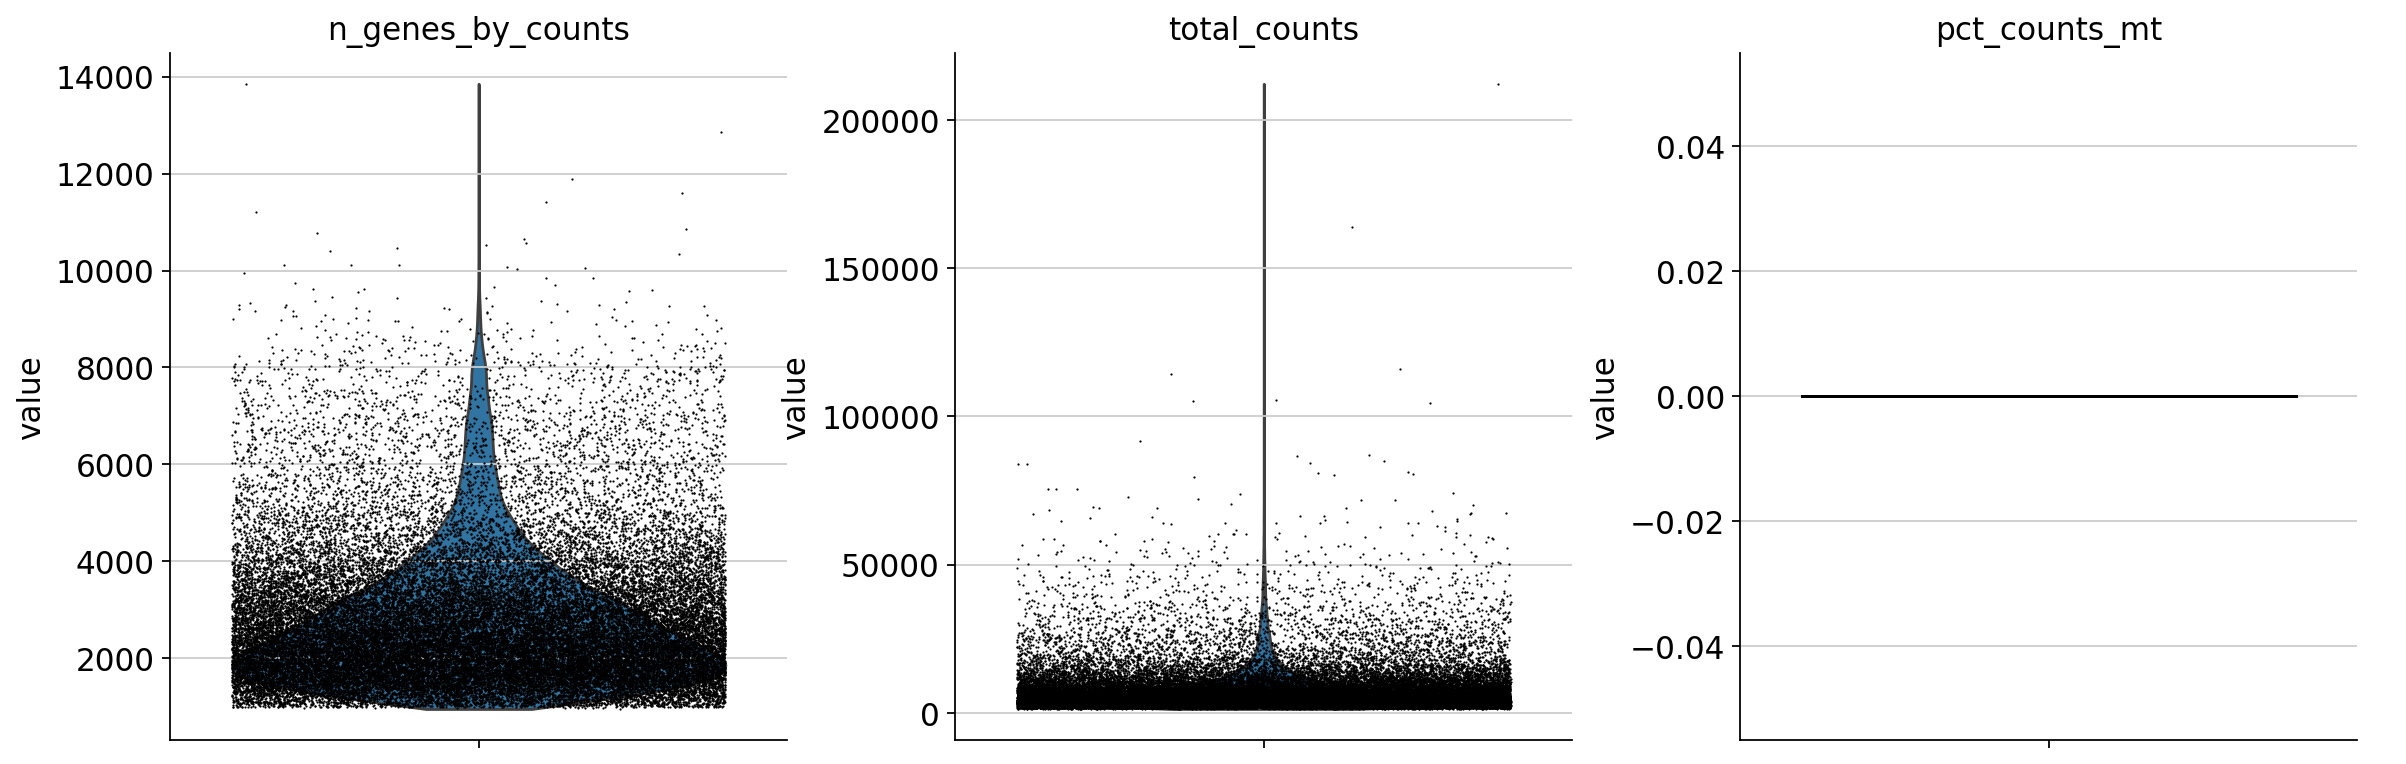

In [38]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)

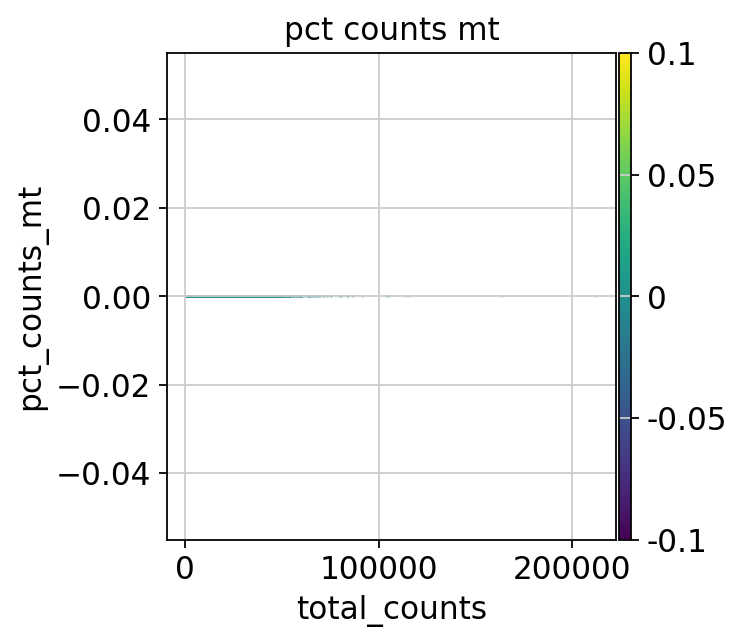

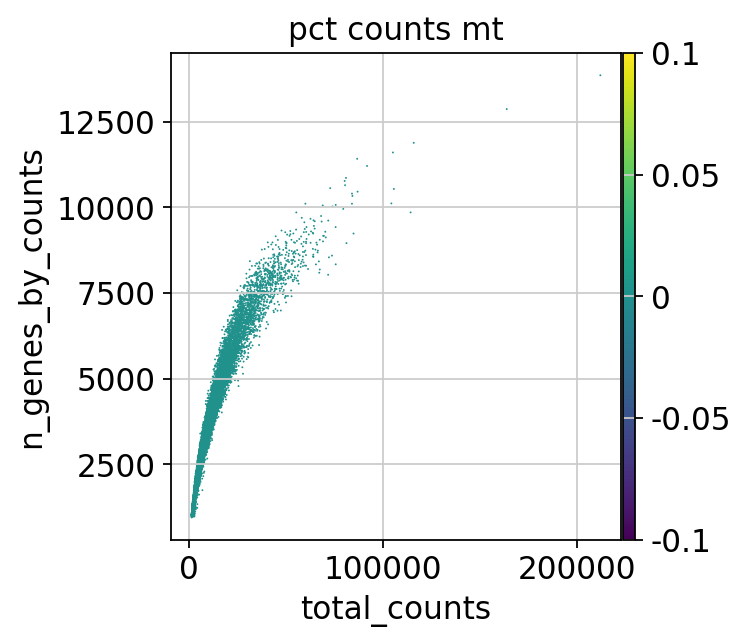

In [39]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Outlier Threshold**

#### ***MAD = median(|Xi - median(X)|)***
Xi is the respective QC metric of an observation and 
describes a robust statistic of the variability of the metric.
[Germain et al., 2020]

In [ ]:
#def is_outlier(merged_adata, metric: str, nmads: int):
#    M = merged_adata.obs[metric]
#    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
#        np.median(M) + nmads * median_abs_deviation(M) < M
#    )
#    return outlier

In [ ]:
#merged_adata.obs["outlier"] = (
#    is_outlier(merged_adata, "log1p_total_counts", 5) |
#    is_outlier(merged_adata, "log1p_n_genes_by_counts", 5) #|
#    #is_outlier(merged_adata, "pct_counts_in_top_20_genes", 5)    
#)
#merged_adata.obs.outlier.value_counts()

In [ ]:
#merged_adata.obs["mt_outlier"] = is_outlier(merged_adata, "pct_counts_mt", 3) | (
#    merged_adata.obs["pct_counts_mt"] > 20
#)
#merged_adata.obs.mt_outlier.value_counts()

In [ ]:
#print(f"Total number of cells: {merged_adata.n_obs}")
#merged_adata = merged_adata[(~merged_adata.obs.outlier) & (~merged_adata.obs.mt_outlier)].copy()
#
#print(f"Number of cells after filtering of low quality cells: {merged_adata.n_obs}")

In [ ]:
#sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Filtering**

In [69]:
adata

AnnData object with n_obs × n_vars = 41435 × 26737
    obs: 'patient', 'cell_ontology', 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

In [40]:
#print(f"Total number of genes: {merged_adata.n_vars}")
#rsc.pp.filter_cells(merged_adata, min_count=3)
#rsc.pp.filter_cells(merged_adata, max_count=20000)
#print(f"Number of genes after cell filter: {merged_adata.n_vars}")


adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]

In [41]:
rsc.pp.filter_genes(adata, min_count=3)

filtered out 62 genes based on n_cells_by_counts


In [42]:
adata

AnnData object with n_obs × n_vars = 41127 × 26675
    obs: 'Patient', 'cell_ontology', 'Conditions', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

### **Plot after filtering**

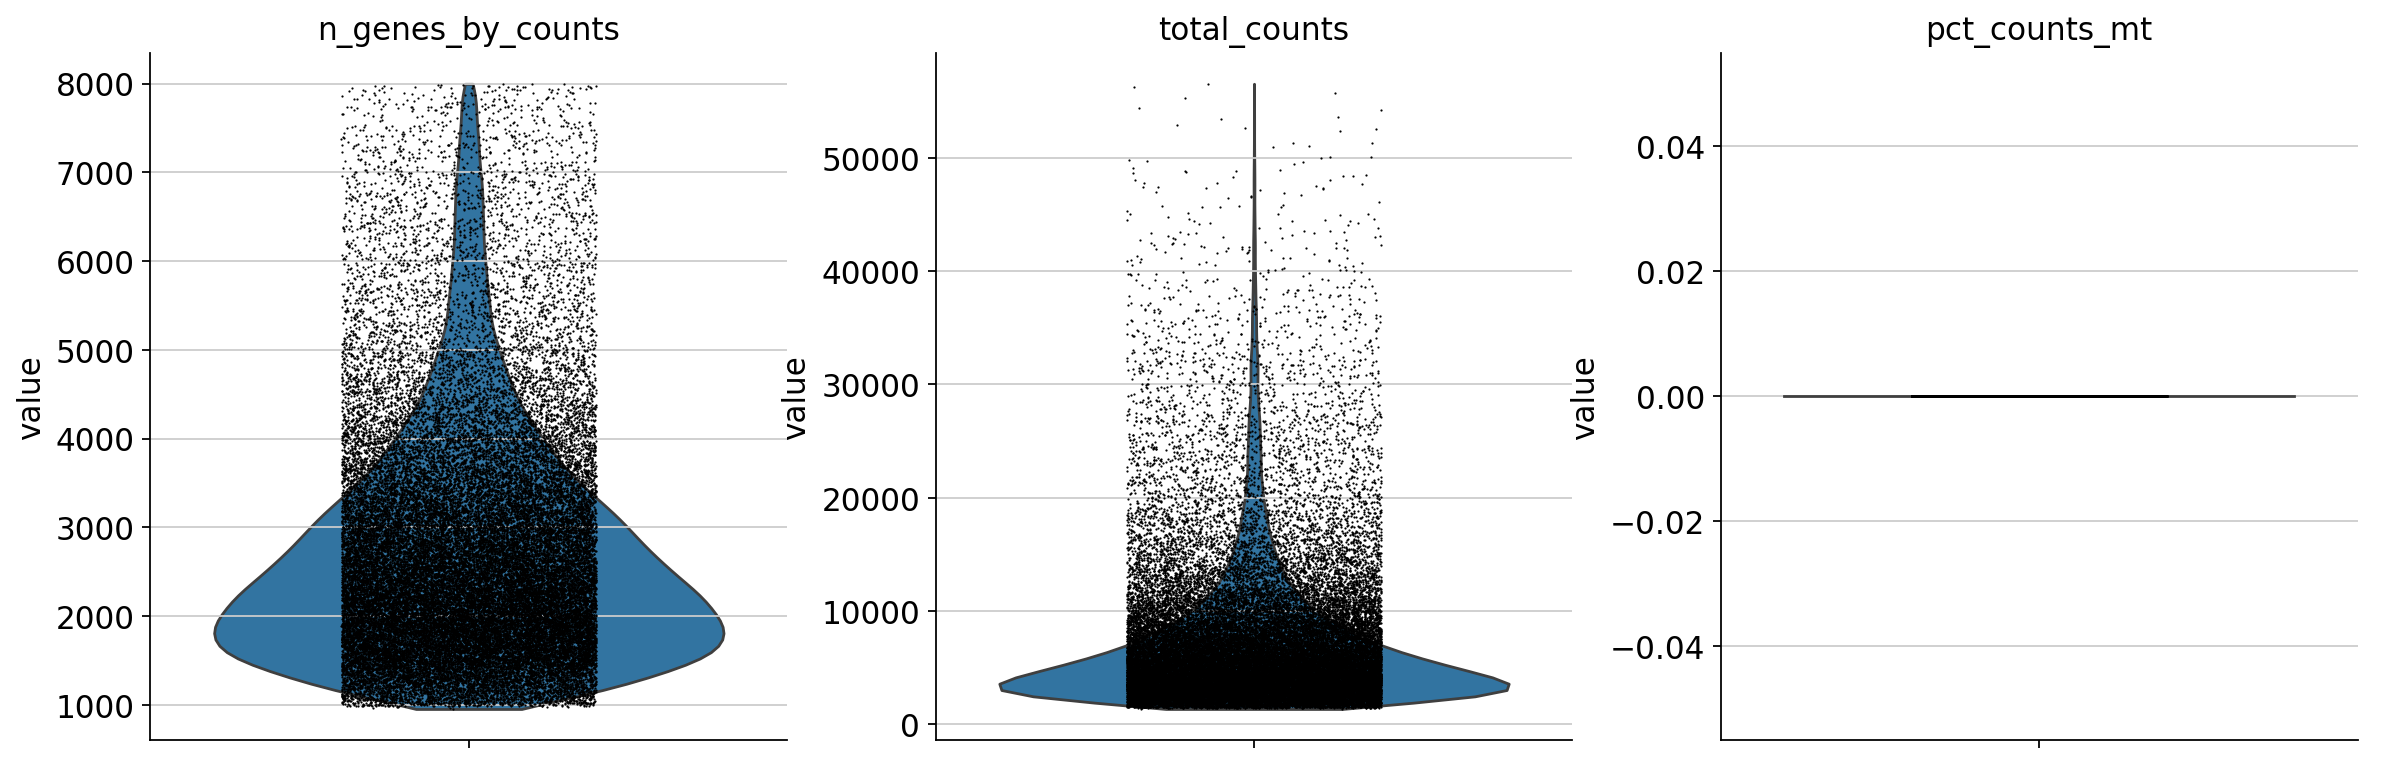

In [43]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True)

In [44]:
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 41127 × 26675
    obs: 'Patient', 'cell_ontology', 'Conditions', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    layers: 'counts'

In [45]:
adata.shape

(41127, 26675)

In [47]:
adata.write("/home/supakorn/rscript/results/GSE157783/GSE157783_no_norm.h5ad")

## **Normalization**

In [77]:
rsc.pp.normalize_total(adata, target_sum=1e4)

In [78]:
rsc.pp.log1p(adata)

In [79]:
adata.X[1,:].sum()

array(4609.076, dtype=float32)

In [80]:
rsc.pp.highly_variable_genes(adata, flavor="seurat_v3")


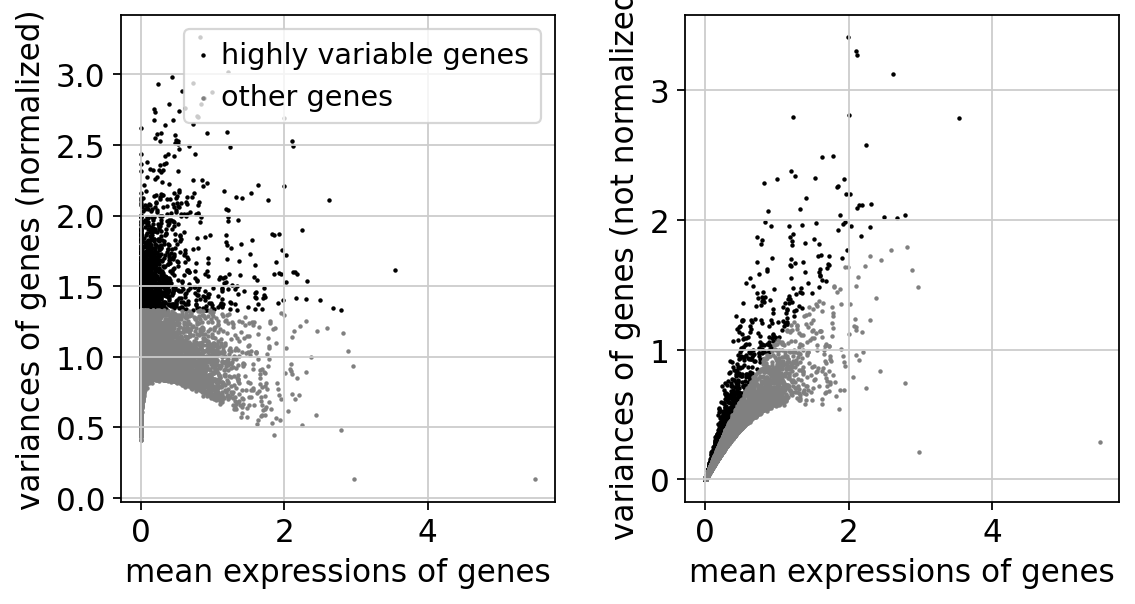

In [81]:
sc.pl.highly_variable_genes(adata)

In [84]:
adata = adata[:, adata.var["highly_variable"]]

In [85]:
adata.X

### Create .raw file

In [ ]:
#adata.raw = adata

In [ ]:
#adata = adata[:, adata.var.highly_variable]

In [ ]:
#adata.raw.X

## **Regress out unwanted variable**

In [86]:
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_mt"])

## **Scale Data**

In [87]:
rsc.pp.scale(adata, max_value=10)

## **Plot PCA**

In [88]:
rsc.pp.pca(adata, n_comps=100)

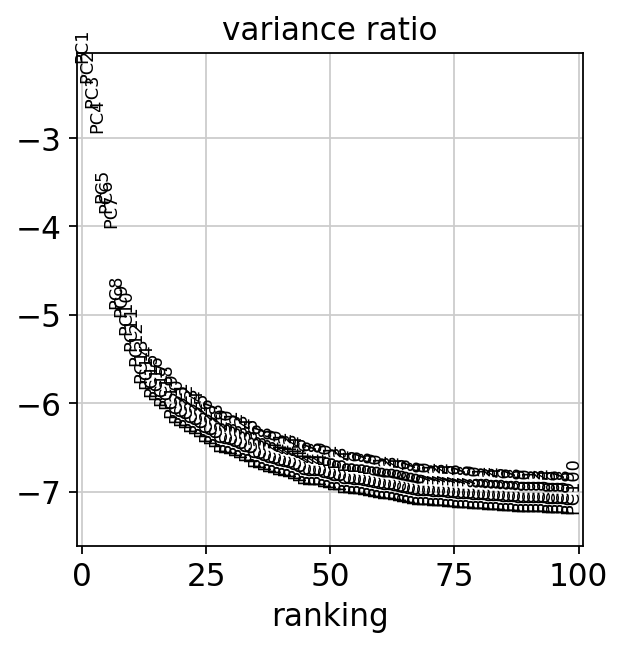

In [90]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

In [92]:
rsc.get.anndata_to_CPU(adata, convert_all=True)

In [95]:
adata.layers['counts']

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 9474418 stored elements in Compressed Sparse Row format>

In [96]:
adata.X.shape

(41433, 2000)

In [97]:
sparse_matrix_after = sp.csr_matrix(adata.X)
adata.X = sparse_matrix_after

In [98]:
adata.X

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 82866000 stored elements in Compressed Sparse Row format>

In [99]:
adata.write(results_file)

In [ ]:
#adata_obs_df = pd.DataFrame(adata.obs)

In [ ]:
#adata_obs_df

In [ ]:
#adata_var_df = pd.DataFrame(adata.var)
#adata_var_df

### **Batch Correction**

In [100]:
rsc.pp.harmony_integrate(adata, key="patient")

2024-04-09 21:08:04,332 - harmonypy_gpu - INFO - Iteration 1 of 10
2024-04-09 21:08:09,745 - harmonypy_gpu - INFO - Iteration 2 of 10
2024-04-09 21:08:15,064 - harmonypy_gpu - INFO - Iteration 3 of 10
2024-04-09 21:08:20,294 - harmonypy_gpu - INFO - Iteration 4 of 10
2024-04-09 21:08:25,560 - harmonypy_gpu - INFO - Iteration 5 of 10
2024-04-09 21:08:31,001 - harmonypy_gpu - INFO - Converged after 5 iterations


## **Find Neighbors**

In [101]:
rsc.pp.neighbors(adata, n_neighbors=100, n_pcs=50)

In [102]:
rsc.tl.umap(adata)
rsc.tl.tsne(adata, perplexity=5000, learning_rate=200, early_exaggeration=24)


[W] [21:09:04.245321] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [21:09:04.245422] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


## **Clustering and Visualization**

In [103]:
rsc.tl.leiden(adata, resolution=0.5)
rsc.tl.louvain(adata, resolution=0.5)

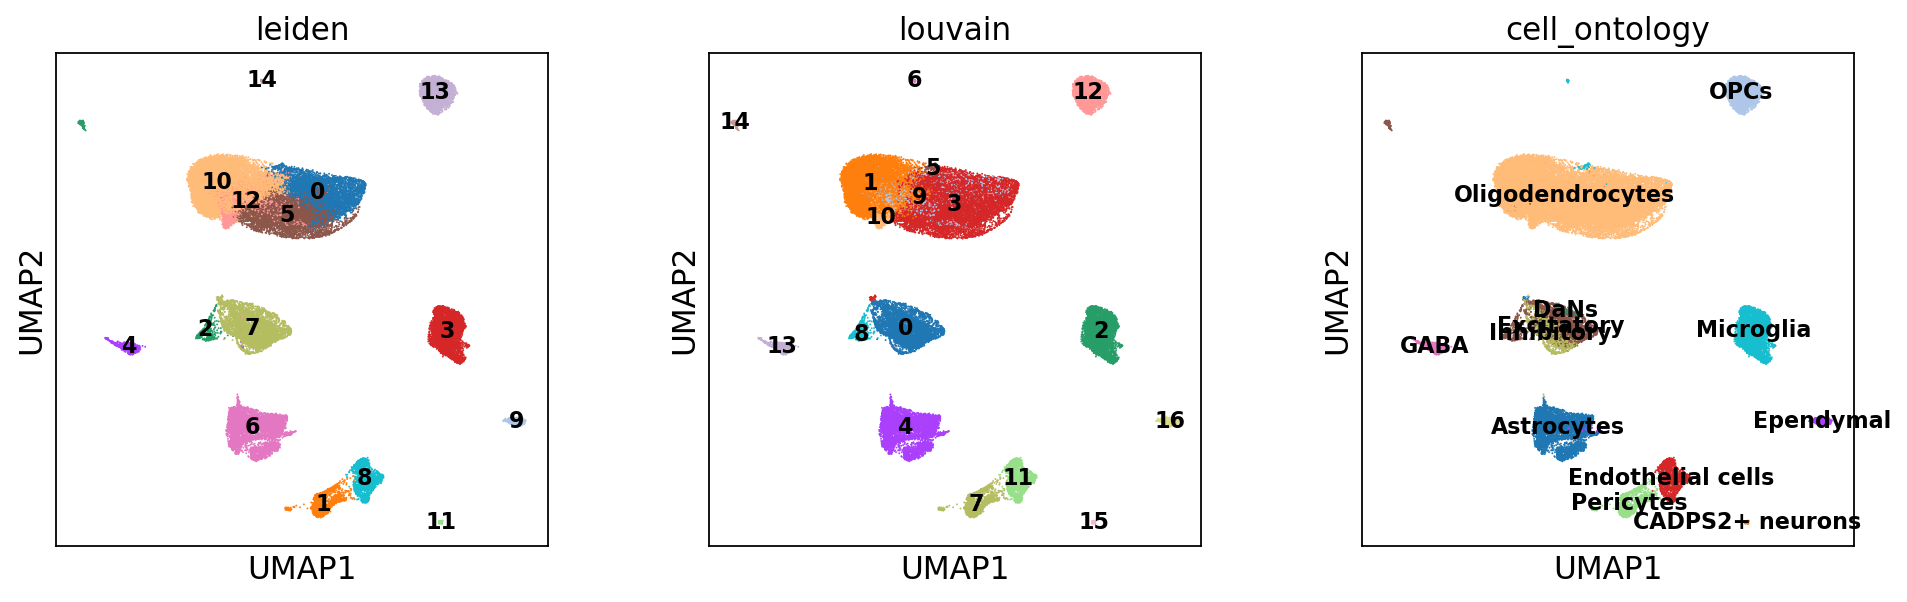

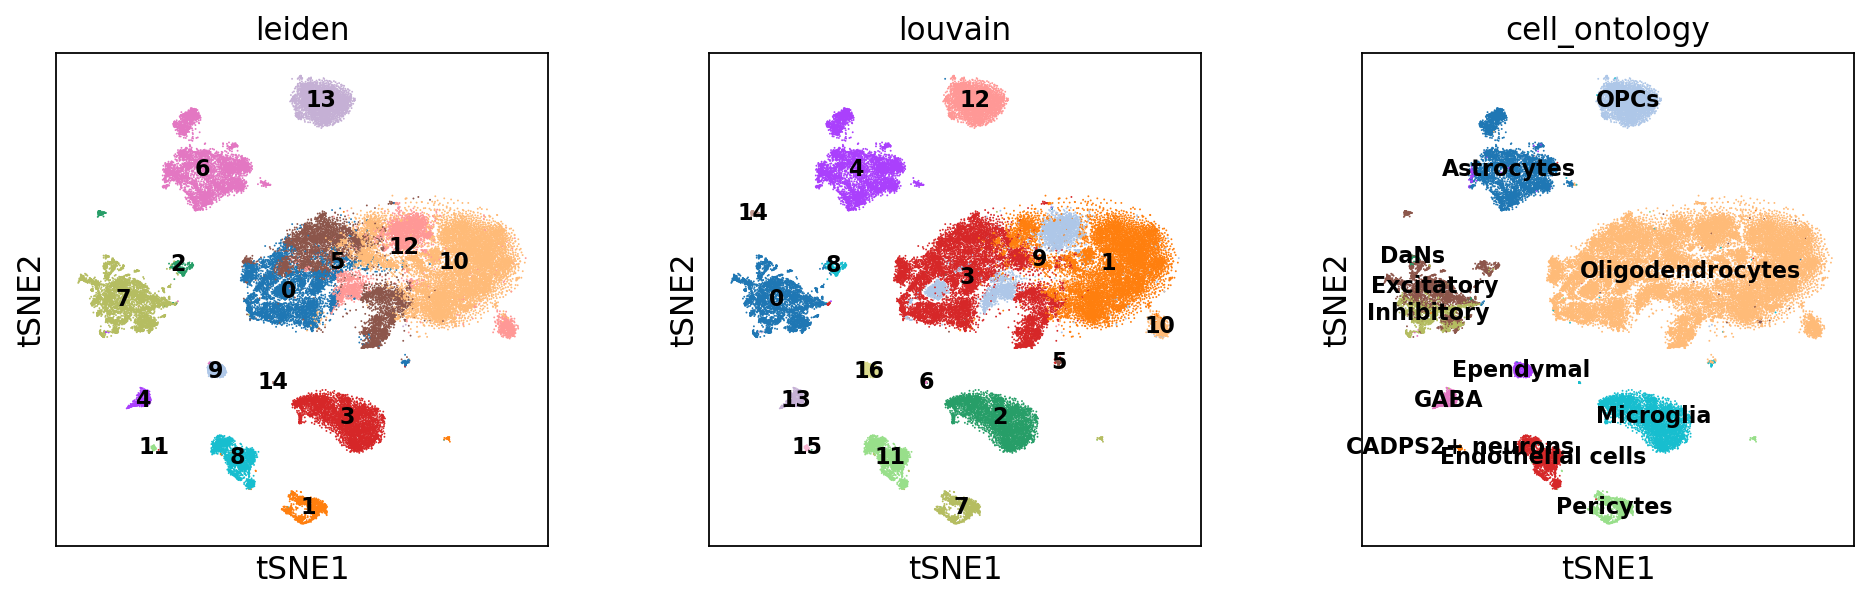

In [104]:
sc.pl.umap(adata, color=["leiden", "louvain", "cell_ontology"], legend_loc="on data", legend_fontsize=10)
sc.pl.tsne(adata, color=["leiden", "louvain", "cell_ontology"], legend_loc="on data", legend_fontsize=10)

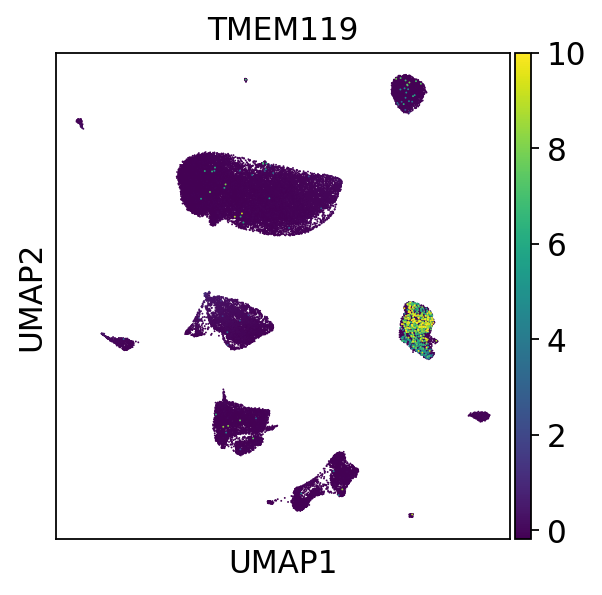

In [107]:
sc.pl.umap(adata, color=["TMEM119"], legend_loc="on data", use_raw=False, legend_fontsize=10)

In [108]:
adata.X

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 82866000 stored elements in Compressed Sparse Row format>

In [110]:
adata.layers['counts']

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 9474418 stored elements in Compressed Sparse Row format>

In [111]:
adata.write(results_file)

### UMAP and TSNE with Kmeans

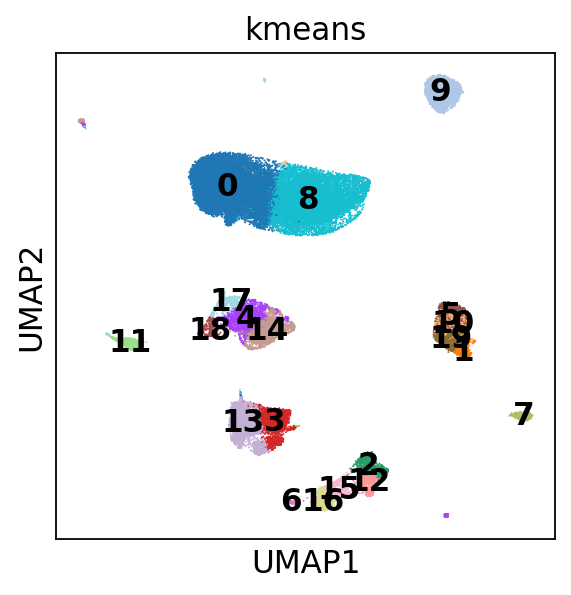

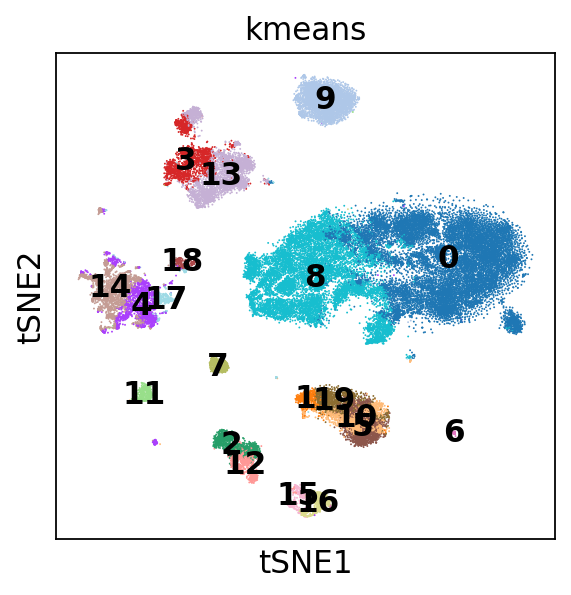

In [112]:
rsc.tl.kmeans(adata, n_clusters=20)

sc.pl.umap(adata, color=["kmeans"], legend_loc = 'on data')
sc.pl.tsne(adata, color=["kmeans"], legend_loc = 'on data')

### Embedding density in the UMAP

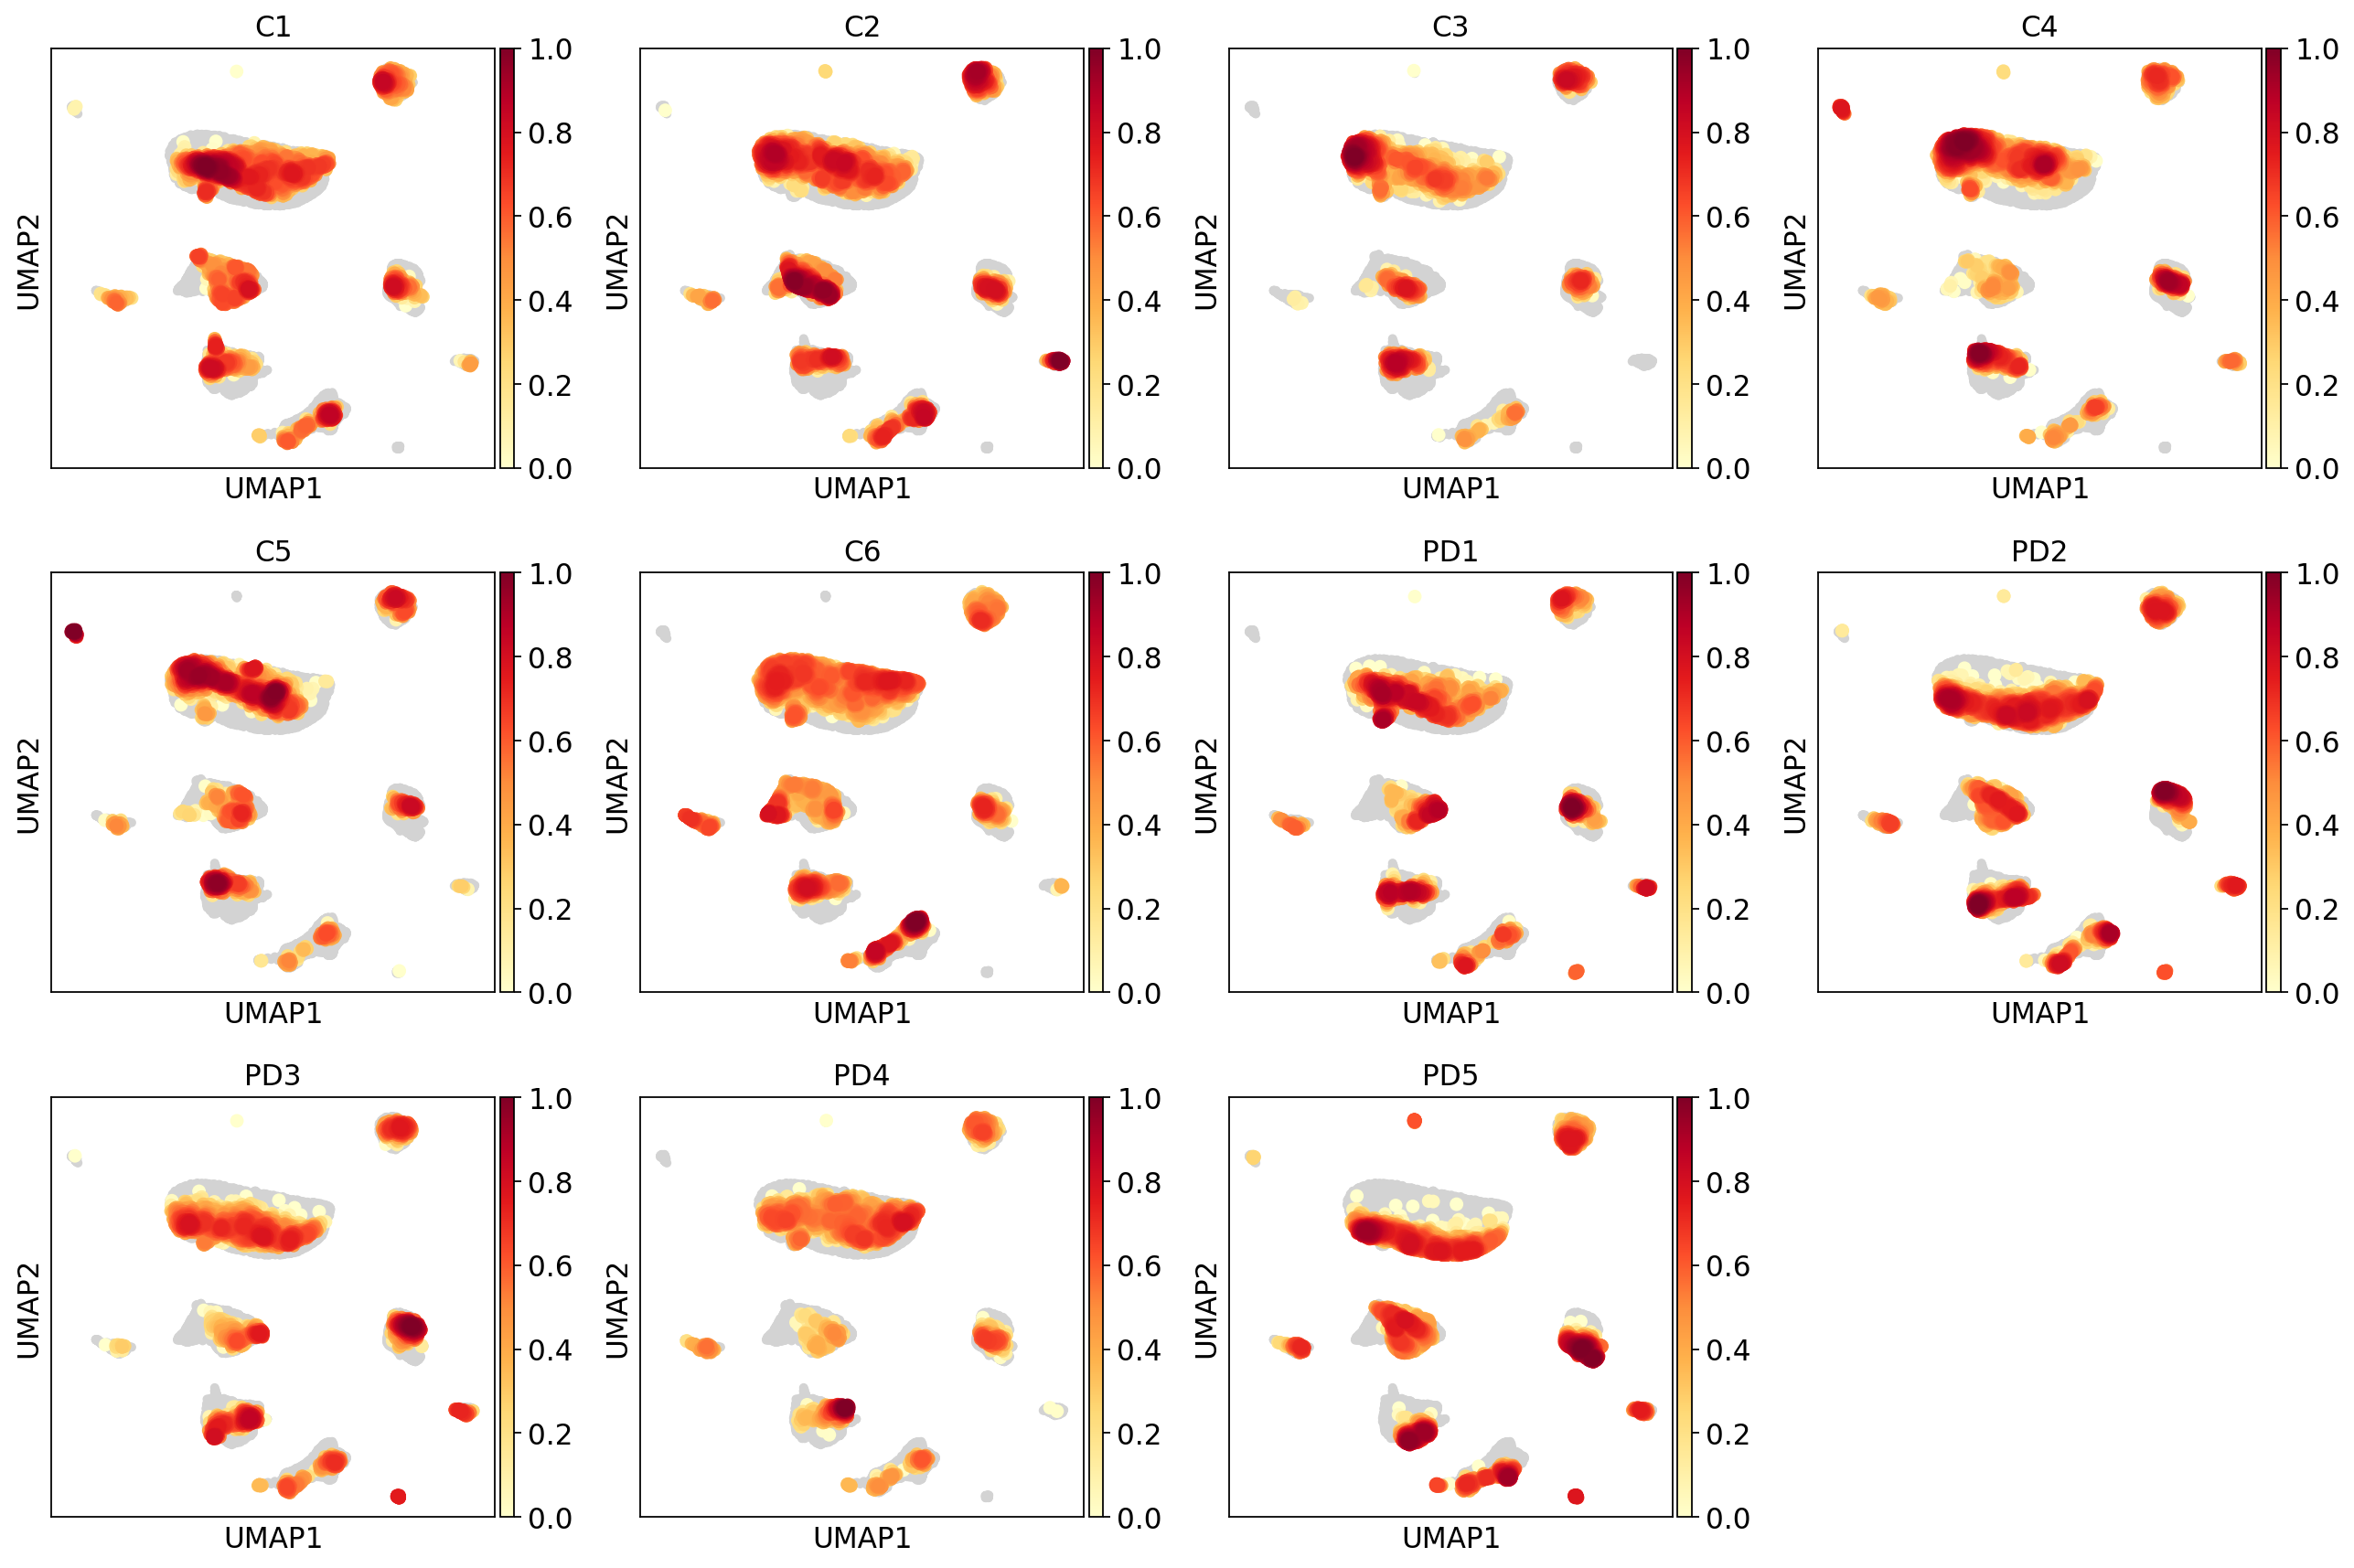

In [113]:
rsc.tl.embedding_density(adata, groupby="patient")
sc.pl.embedding_density(adata, groupby="patient")

## **DE analysis**

[W] [21:13:21.676143] L-BFGS: max iterations reached
[W] [21:13:21.677504] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


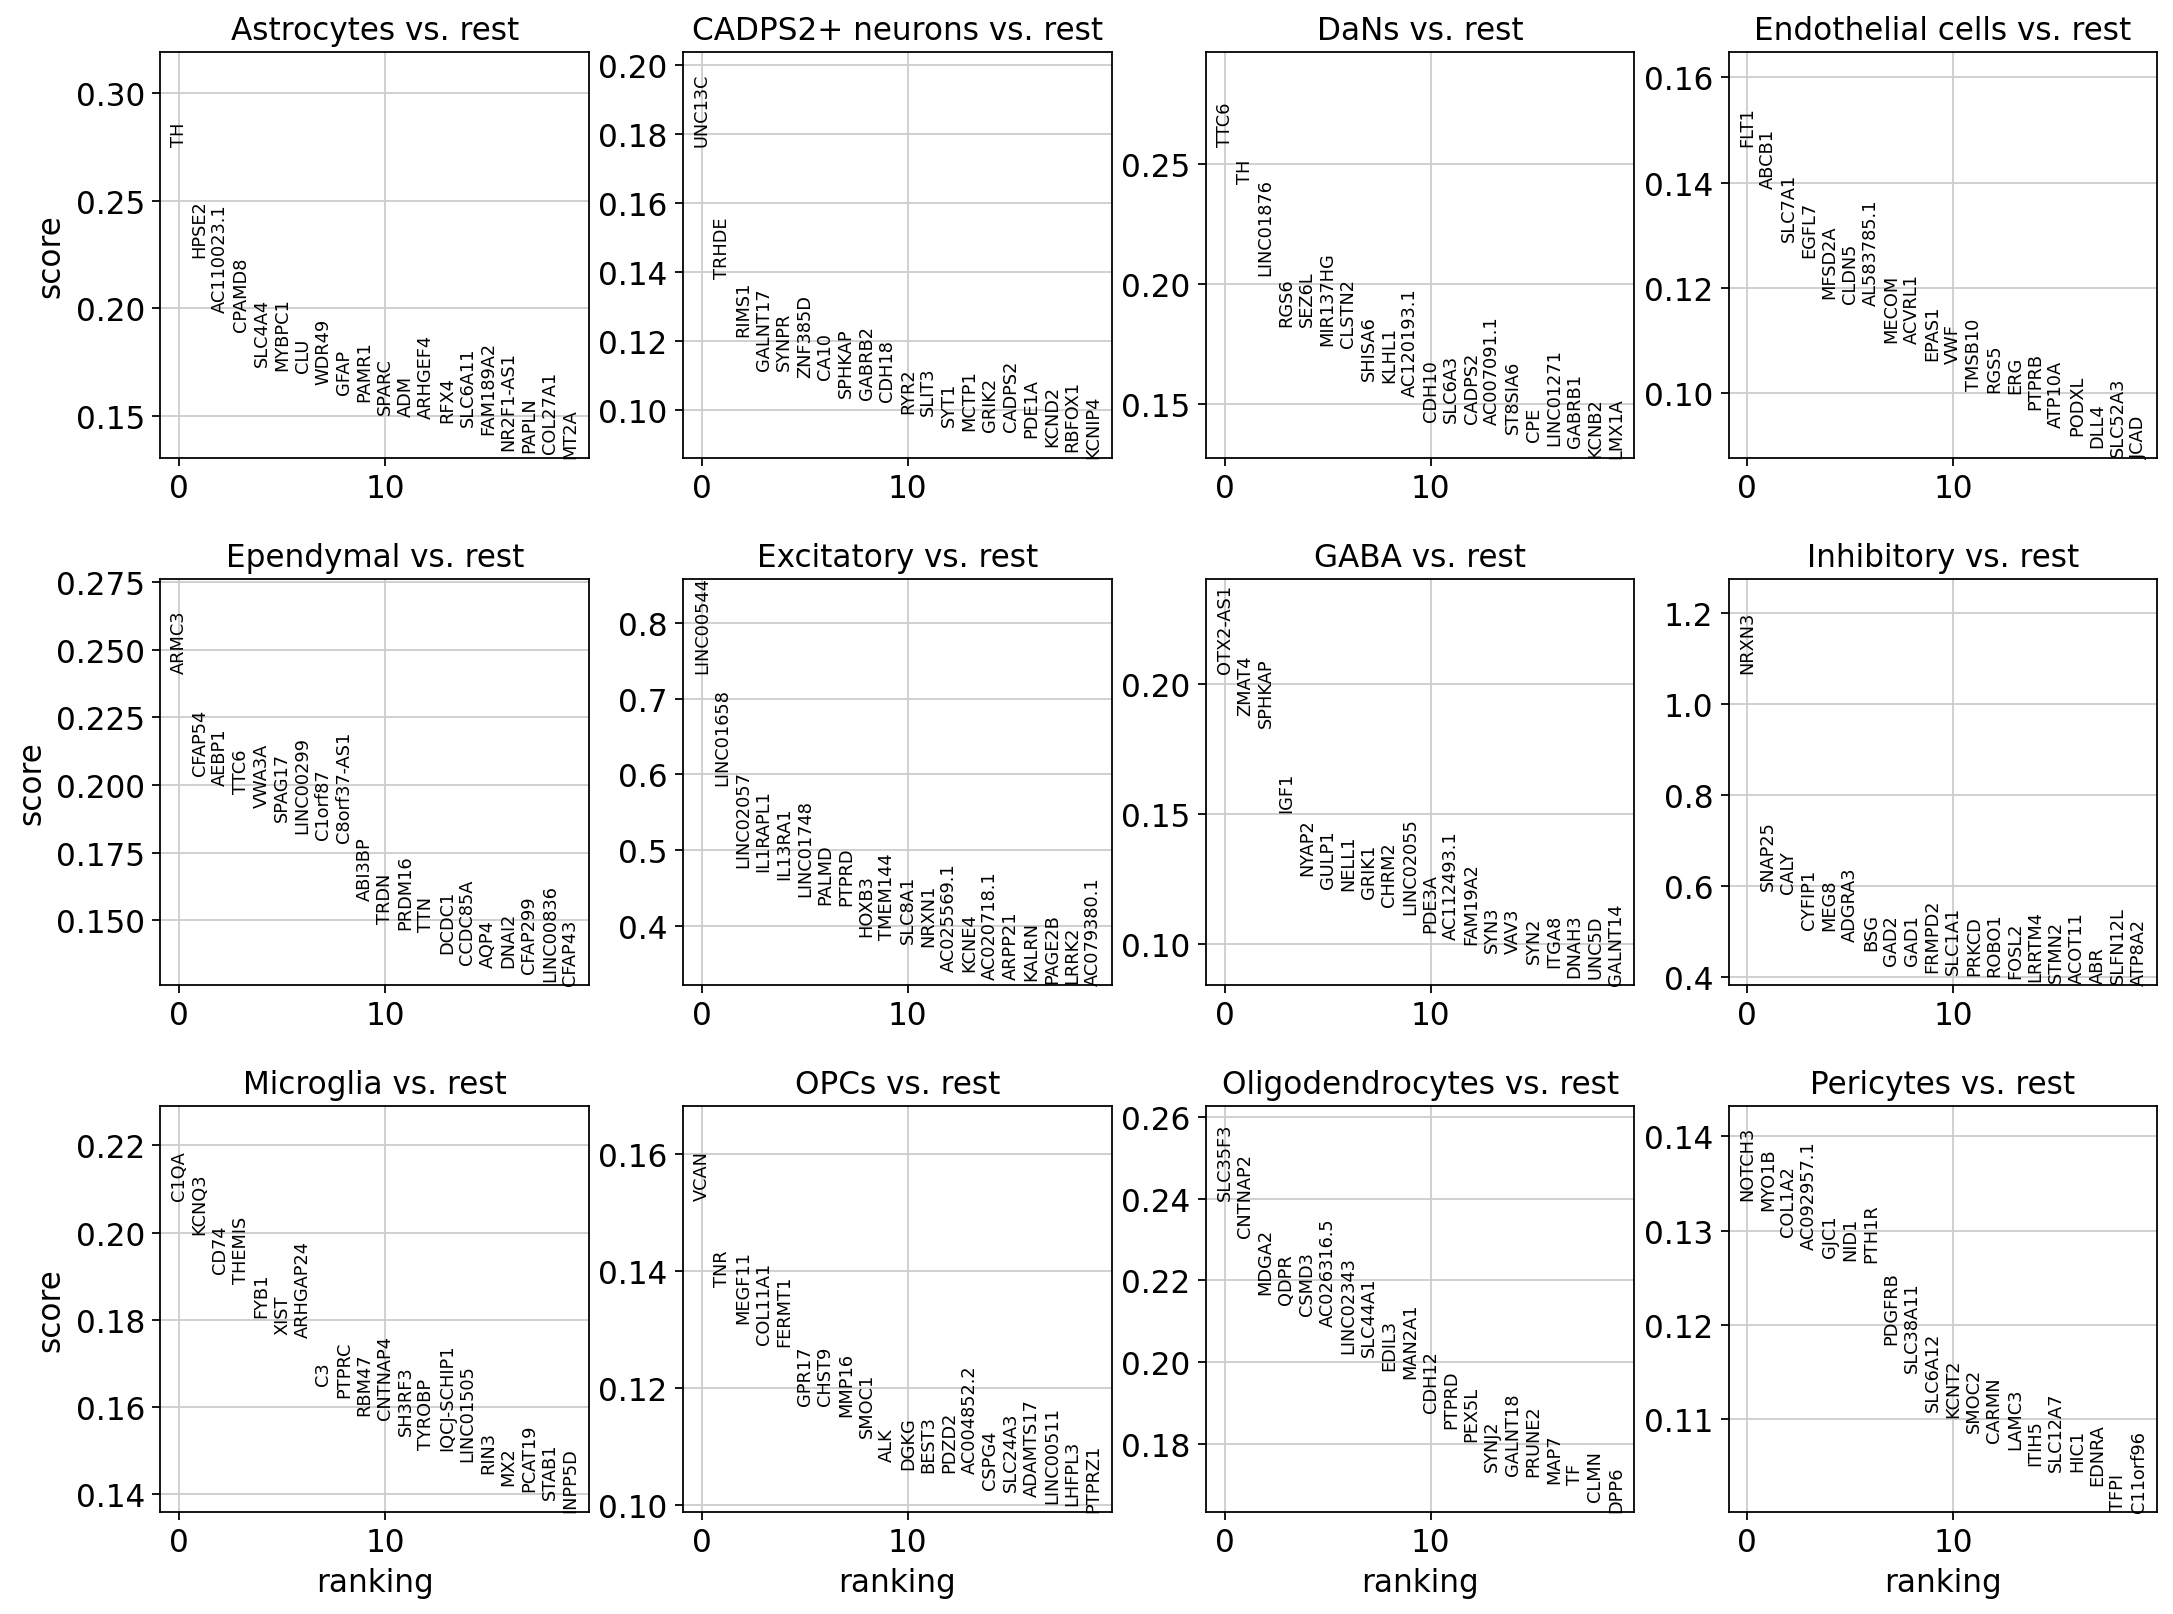

In [114]:
# Methods can be 't-test', 't-test_overestim_var' for overreestimates varience of each group
# 'wilcoxon' for rank-sum
# 'logreg' for logistic regression

rsc.tl.rank_genes_groups_logreg(adata, groupby="cell_ontology", use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=4)

In [115]:
sc.settings.verbosity = 2  # reduce the verbosity
adata.write(results_file)

In [ ]:
#sc.tl.rank_genes_groups(merged_adata, "leiden", method="wilcoxon")
#sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [ ]:
#sc.tl.rank_genes_groups(merged_adata, "leiden", method="logreg", max_iter=1000)
#sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [ ]:
#adata = sc.read(results_file)

In [116]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

Astrocytes CADPS2+ neurons        DaNs Endothelial cells    Ependymal  \
0          TH          UNC13C        TTC6              FLT1        ARMC3   
1       HPSE2           TRHDE          TH             ABCB1       CFAP54   
2  AC110023.1           RIMS1   LINC01876            SLC7A1        AEBP1   
3      CPAMD8         GALNT17        RGS6             EGFL7         TTC6   
4      SLC4A4           SYNPR       SEZ6L            MFSD2A        VWA3A   
5      MYBPC1         ZNF385D    MIR137HG             CLDN5       SPAG17   
6         CLU            CA10      CLSTN2        AL583785.1    LINC00299   
7       WDR49          SPHKAP      SHISA6             MECOM      C1orf87   
8        GFAP          GABRB2       KLHL1            ACVRL1  C8orf37-AS1   
9       PAMR1           CDH18  AC120193.1             EPAS1       ABI3BP   

  Excitatory       GABA Inhibitory Microglia     OPCs Oligodendrocytes  \
0  LINC00544   OTX2-AS1      NRXN3      C1QA     VCAN          SLC35F3   
1  LINC01658      ZMAT4     SNAP25     KCNQ3      TNR          CNTNAP2   
2  LINC02057     SPHKAP       CALY      CD74   MEGF11            MDGA2   
3   IL1RAPL1       IGF1     CYFIP1    THEMIS  COL11A1             QDPR   
4    IL13RA1      NYAP2       MEG8      FYB1   FERMT1            CSMD3   
5  LINC01748      GULP1     ADGRA3      XIST    GPR17       AC026316.5   
6      PALMD      NELL1        BSG  ARHGAP24    CHST9        LINC02343   
7      PTPRD      GRIK1       GAD2        C3    MMP16          SLC44A1   
8      HOXB3      CHRM2       GAD1     PTPRC    SMOC1            EDIL3   
9    TMEM144  LINC02055     FRMPD2     RBM47      ALK           MAN2A1   

    Pericytes  
0      NOTCH3  
1       MYO1B  
2      COL1A2  
3  AC092957.1  
4        GJC1  
5        NID1  
6       PTH1R  
7      PDGFRB  
8    SLC38A11  
9     SLC6A12

In [117]:
adata.uns

OrderedDict([('log1p', {'base': None}),
             ('hvg', {'flavor': 'seurat_v3'}),
             ('pca',
              {'params': {'zero_center': True, 'use_highly_variable': True},
               'variance': array([164.42726  , 130.97229  ,  98.23011  ,  74.57065  ,  33.601173 ,
                       30.027086 ,  25.35155  ,  10.171174 ,   9.223769 ,   7.5370116,
                        6.303449 ,   5.3006725,   4.399288 ,   4.101682 ,   3.7383633,
                        3.6072135,   3.395235 ,   3.2736301,   2.9502158,   2.7868304,
                        2.7045538,   2.639866 ,   2.526083 ,   2.4552145,   2.3911219,
                        2.2502928,   2.200806 ,   2.1317348,   2.024384 ,   1.9988028,
                        1.9682438,   1.9298031,   1.8792816,   1.818085 ,   1.8055617,
                        1.692264 ,   1.679412 ,   1.6345158,   1.6107085,   1.5858992,
                        1.5450605,   1.5382032,   1.5139933,   1.4908601,   1.4576228,
                    

In [118]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names"]
    }
).head(10)

Astrocytes_n CADPS2+ neurons_n      DaNs_n Endothelial cells_n  Ependymal_n  \
0           TH            UNC13C        TTC6                FLT1        ARMC3   
1        HPSE2             TRHDE          TH               ABCB1       CFAP54   
2   AC110023.1             RIMS1   LINC01876              SLC7A1        AEBP1   
3       CPAMD8           GALNT17        RGS6               EGFL7         TTC6   
4       SLC4A4             SYNPR       SEZ6L              MFSD2A        VWA3A   
5       MYBPC1           ZNF385D    MIR137HG               CLDN5       SPAG17   
6          CLU              CA10      CLSTN2          AL583785.1    LINC00299   
7        WDR49            SPHKAP      SHISA6               MECOM      C1orf87   
8         GFAP            GABRB2       KLHL1              ACVRL1  C8orf37-AS1   
9        PAMR1             CDH18  AC120193.1               EPAS1       ABI3BP   

  Excitatory_n     GABA_n Inhibitory_n Microglia_n   OPCs_n  \
0    LINC00544   OTX2-AS1        NRXN3        C1QA     VCAN   
1    LINC01658      ZMAT4       SNAP25       KCNQ3      TNR   
2    LINC02057     SPHKAP         CALY        CD74   MEGF11   
3     IL1RAPL1       IGF1       CYFIP1      THEMIS  COL11A1   
4      IL13RA1      NYAP2         MEG8        FYB1   FERMT1   
5    LINC01748      GULP1       ADGRA3        XIST    GPR17   
6        PALMD      NELL1          BSG    ARHGAP24    CHST9   
7        PTPRD      GRIK1         GAD2          C3    MMP16   
8        HOXB3      CHRM2         GAD1       PTPRC    SMOC1   
9      TMEM144  LINC02055       FRMPD2       RBM47      ALK   

  Oligodendrocytes_n Pericytes_n  
0            SLC35F3      NOTCH3  
1            CNTNAP2       MYO1B  
2              MDGA2      COL1A2  
3               QDPR  AC092957.1  
4              CSMD3        GJC1  
5         AC026316.5        NID1  
6          LINC02343       PTH1R  
7            SLC44A1      PDGFRB  
8              EDIL3    SLC38A11  
9             MAN2A1     SLC6A12

In [ ]:
#sc.tl.rank_genes_groups(adata, "leiden", groups=["3"], reference="15", method="wilcoxon")
#sc.pl.rank_genes_groups(adata, groups=["3"], n_genes=20)

## **pyDESeq2 (pseudobulk)** 

In [119]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [120]:
adata.X

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 82866000 stored elements in Compressed Sparse Row format>

In [121]:
adata.layers['counts']

<41433x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 9474418 stored elements in Compressed Sparse Row format>

In [122]:
microglia_subset = adata[adata.obs['cell_ontology'] == 'Microglia', :].copy()
microglia_subset

AnnData object with n_obs × n_vars = 3903 × 2000
    obs: 'patient', 'cell_ontology', 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'leiden', 'louvain', 'kmeans', 'umap_density_patient'
    var: 'gene', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'louvain', 'leiden_colors', 'louvain_colors', 'cell_ontology_colors', 'kmeans_colors', 'umap_density_patient_params', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [123]:
microglia_subset.obs.groupby(['condition']).size()

condition
Control    1205
PD         2698
dtype: int64

In [124]:
microglia_subset.X

<3903x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 7806000 stored elements in Compressed Sparse Row format>

In [126]:
microglia_subset.shape

(3903, 2000)

In [135]:
pbs = []

for patient in microglia_subset.obs.patient.unique():
    
    patient_microglia_subset = microglia_subset[microglia_subset.obs['patient'] == patient, :].copy()
    patient_microglia_subset.X = patient_microglia_subset.layers['counts'] #change to raw counts using array
    
    rep_adata = sc.AnnData(X = patient_microglia_subset.X.sum(axis=0),
                           var=patient_microglia_subset.var[[]])
    
    rep_adata.obs_names = [patient]
    rep_adata.obs['condition'] = patient_microglia_subset.obs['condition'].iloc[0]
    
    pbs.append(rep_adata)

In [136]:
pb = sc.concat(pbs)
pb

AnnData object with n_obs × n_vars = 11 × 2000
    obs: 'condition'

In [138]:
pb.obs

condition
PD3        PD
PD5        PD
PD1        PD
C6    Control
C4    Control
C5    Control
C1    Control
C3    Control
C2    Control
PD2        PD
PD4        PD

In [191]:
pb.var['gene'] = pb.var_names.values

In [196]:
counts = pd.DataFrame(pb.X, columns = pb.var['gene']) # to pass var names into dataframe with sparse pb

In [197]:
counts

gene  AL645608.8  HES4  HES5  PRDM16  SLC2A5  TNFRSF1B   KAZN  TMEM51  SRARP  \
0            0.0   5.0   0.0     3.0   537.0     228.0   60.0   177.0    0.0   
1            1.0   6.0   0.0    10.0  2863.0    2231.0  157.0  2186.0    5.0   
2            0.0   0.0   0.0     1.0   188.0     165.0   39.0   116.0    0.0   
3            0.0   2.0   0.0     0.0   445.0     204.0   63.0   113.0    2.0   
4            0.0   2.0   0.0     1.0   430.0     491.0   24.0   221.0    0.0   
5            0.0   1.0   0.0     0.0   108.0      95.0   93.0    63.0    0.0   
6            0.0   3.0   0.0     7.0   222.0     206.0  182.0   119.0    0.0   
7            0.0   1.0   0.0     5.0   134.0      66.0   11.0    55.0    0.0   
8            0.0   1.0   1.0     2.0   332.0     259.0   25.0   109.0    1.0   
9            0.0   2.0   0.0     3.0   499.0     375.0   91.0   347.0    0.0   
10           0.0   0.0   0.0     0.0   211.0     179.0   15.0   105.0    0.0   

gene  IGSF21  ...  ENOX1-AS2  LINC00330  GPR33  AC092134.1  MIR497HG  \
0      359.0  ...        0.0        0.0    0.0         0.0       0.0   
1     1662.0  ...        0.0        0.0    0.0         0.0       0.0   
2      361.0  ...        0.0        0.0    0.0         0.0       0.0   
3      575.0  ...        0.0        0.0    0.0         0.0       0.0   
4      992.0  ...        0.0        0.0    0.0         0.0       0.0   
5      128.0  ...        0.0        0.0    0.0         0.0       0.0   
6      355.0  ...        0.0        0.0    0.0         0.0       0.0   
7      102.0  ...        0.0        0.0    0.0         0.0       0.0   
8      426.0  ...        0.0        0.0    0.0         0.0       0.0   
9      854.0  ...        0.0        1.0    0.0         1.0       0.0   
10     186.0  ...        0.0        0.0    0.0         0.0       0.0   

gene  AC025521.1  AC107892.1  ZNF816  AC004832.6  Z83847.1  
0            0.0         0.0     0.0         0.0       0.0  
1            0.0         0.0     0.0         0.0       0.0  
2            0.0         0.0     0.0         0.0       0.0  
3            0.0         0.0     0.0         0.0       0.0  
4            0.0         0.0     0.0         0.0       0.0  
5            0.0         0.0     0.0         0.0       0.0  
6            0.0         0.0     0.0         0.0       0.0  
7            0.0         0.0     0.0         0.0       0.0  
8            0.0         0.0     0.0         0.0       0.0  
9            0.0         3.0     1.0         0.0       0.0  
10           0.0         0.0     0.0         0.0       0.0  

[11 rows x 2000 columns]

In [198]:
dds = DeseqDataSet(counts=counts, 
                   metadata=pb.obs, 
                   design_factors="condition")

#design_factors = ['batch', 'condition'] = ~ batch + condition

In [199]:
dds

AnnData object with n_obs × n_vars = 11 × 2000
    obs: 'condition'
    obsm: 'design_matrix'

In [200]:
sc.pp.filter_genes(dds, min_cells=1)

filtered out 232 genes that are detected in less than 1 cells


In [201]:
dds

AnnData object with n_obs × n_vars = 11 × 1768
    obs: 'condition'
    var: 'n_cells'
    obsm: 'design_matrix'

In [202]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Fitting dispersions...
... done in 2.23 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 2.41 seconds.

Fitting LFCs...
... done in 1.57 seconds.

Replacing 0 outlier genes.



computing PCA
    with n_comps=10
    finished (0:00:00)


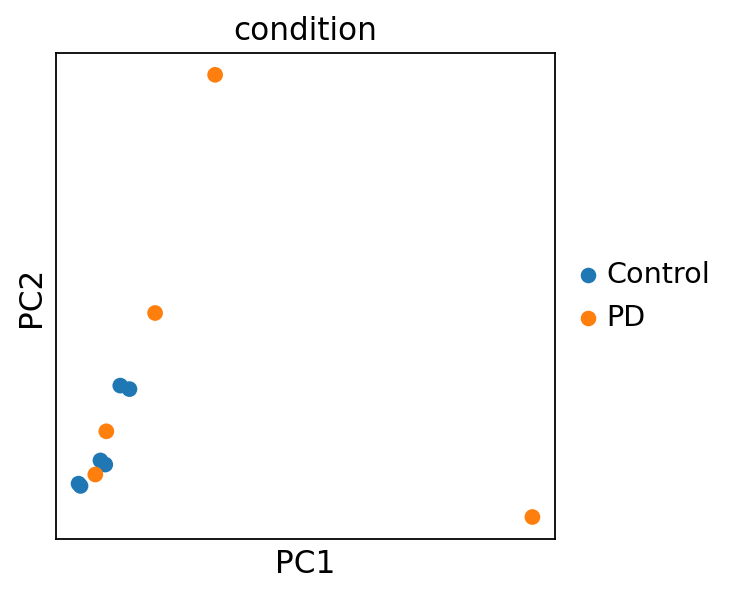

In [203]:
sc.tl.pca(dds)
sc.pl.pca(dds, color='condition', size = 200)

In [204]:
start_res = DeseqStats(dds, contrast=('condition', 'PD', 'Control'))
start_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition PD vs Control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene                                                                          
AL645608.8    0.015216       -0.610977  3.499108 -0.174609  0.861387       NaN
HES4          1.700581       -0.889910  0.899871 -0.988931  0.322697       NaN
HES5          0.129761       -1.461156  3.490620 -0.418595  0.675512       NaN
PRDM16        2.905447       -1.517207  1.072143 -1.415116  0.157034       NaN
SLC2A5      355.966673       -0.036588  0.296497 -0.123400  0.901790  0.950637
...                ...             ...       ...       ...       ...       ...
ASCL4         0.151271        0.783185  3.337547  0.234659  0.814473       NaN
LINC00330     0.037818       -0.286958  3.450110 -0.083174  0.933714       NaN
AC092134.1    0.037818       -0.286958  3.450110 -0.083174  0.933714       NaN
AC107892.1    0.113453        0.509477  3.360300  0.151616  0.879489 

... done in 0.78 seconds.



In [205]:
de = start_res.results_df

In [206]:
de.sort_values('stat', ascending=False)

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene                                                                        
ROR2          37.003927        3.302959  0.631542  5.229993  1.695167e-07   
CHSY3        285.016250        0.857557  0.179201  4.785456  1.705992e-06   
EMP2          11.921626        2.106875  0.465383  4.527189  5.977358e-06   
CHI3L1        62.985337        3.313430  0.731944  4.526889  5.985827e-06   
AC074327.1  1266.386104        1.336221  0.315713  4.232395  2.312158e-05   
...                 ...             ...       ...       ...           ...   
LINC01608     39.908829       -4.816892  1.071139 -4.496981  6.892513e-06   
SPOCK1       126.652407       -3.668300  0.810761 -4.524517  6.053354e-06   
AC026316.5    89.366051       -3.969215  0.860852 -4.610796  4.011294e-06   
GRM3          62.589231       -4.540462  0.978508 -4.640190  3.480888e-06   
MOBP         140.601183       -4.271177  0.859996 -4.966507  6.816973e-07   

                padj  
gene                  
ROR2        0.000165  
CHSY3       0.000554  
EMP2        0.000574  
CHI3L1      0.000574  
AC074327.1  0.001024  
...              ...  
LINC01608   0.000574  
SPOCK1      0.000574  
AC026316.5  0.000574  
GRM3        0.000574  
MOBP        0.000332  

[1768 rows x 6 columns]

In [233]:
de.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj'], dtype='object')

In [235]:
from sanbomics.tools import id_map

In [236]:
de['gene_symbol'] = de.index
de

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene                                                                   
AL645608.8    0.015216       -0.610977  3.499108 -0.174609  0.861387   
HES4          1.700581       -0.889910  0.899871 -0.988931  0.322697   
HES5          0.129761       -1.461156  3.490620 -0.418595  0.675512   
PRDM16        2.905447       -1.517207  1.072143 -1.415116  0.157034   
SLC2A5      355.966673       -0.036588  0.296497 -0.123400  0.901790   
...                ...             ...       ...       ...       ...   
ASCL4         0.151271        0.783185  3.337547  0.234659  0.814473   
LINC00330     0.037818       -0.286958  3.450110 -0.083174  0.933714   
AC092134.1    0.037818       -0.286958  3.450110 -0.083174  0.933714   
AC107892.1    0.113453        0.509477  3.360300  0.151616  0.879489   
ZNF816        0.037818       -0.286958  3.450110 -0.083174  0.933714   

                padj gene_symbol  
gene                              
AL645608.8       NaN  AL645608.8  
HES4             NaN        HES4  
HES5             NaN        HES5  
PRDM16           NaN      PRDM16  
SLC2A5      0.950637      SLC2A5  
...              ...         ...  
ASCL4            NaN       ASCL4  
LINC00330        NaN   LINC00330  
AC092134.1       NaN  AC092134.1  
AC107892.1       NaN  AC107892.1  
ZNF816           NaN      ZNF816  

[1768 rows x 7 columns]

In [237]:
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 0.5)]
sigs

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj  \
gene                                                                         
RAB42     9.888620        3.317469  1.065977  3.112138  0.001857  0.016446   
RNF220  274.351630       -3.278044  0.821434 -3.990636  0.000066  0.001781   
AGBL4    32.568100       -1.047001  0.358207 -2.922895  0.003468  0.025784   
NEGR1    57.301378       -2.682764  0.724068 -3.705127  0.000211  0.003374   
IFI44L  109.958827       -1.279160  0.420422 -3.042561  0.002346  0.018999   
...            ...             ...       ...       ...       ...       ...   
MAG      50.113838       -3.578112  0.894101 -4.001910  0.000063  0.001781   
APLP1    81.497645       -3.089733  0.856309 -3.608199  0.000308  0.004620   
POLR2F   60.196624       -2.457350  0.720912 -3.408667  0.000653  0.007480   
PARVG   142.041233        0.826764  0.311548  2.653728  0.007961  0.048461   
S100B    73.323363       -1.750989  0.641799 -2.728250  0.006367  0.040533   

       gene_symbol  
gene                
RAB42        RAB42  
RNF220      RNF220  
AGBL4        AGBL4  
NEGR1        NEGR1  
IFI44L      IFI44L  
...            ...  
MAG            MAG  
APLP1        APLP1  
POLR2F      POLR2F  
PARVG        PARVG  
S100B        S100B  

[165 rows x 7 columns]

In [238]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])


In [239]:
dds.layers['log1p']

array([[0.        , 1.44529861, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15475779, 0.69527045, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.88680907, 0.88680907, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.60540255, 0.        , ..., 0.3478323 , 0.81003395,
        0.3478323 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [240]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 11 × 165
    obs: 'condition'
    var: 'n_cells'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [241]:
#To make heat map, log1p, var_names and obs_names are required.

heat_map = pd.DataFrame(dds_sigs.layers['log1p'].T,
                        index=dds_sigs.var_names, columns=dds_sigs.obs_names)

heat_map = heat_map.reindex(sorted(heat_map.columns), axis=1)

In [242]:
heat_map

C1        C2        C3        C4        C5        C6       PD1  \
gene                                                                           
RAB42   1.167601  1.349304  0.000000  1.615306  0.000000  0.982463  1.331668   
RNF220  6.931466  3.602349  4.512552  4.196874  7.221915  5.289181  4.038605   
AGBL4   4.011863  3.602349  3.031158  3.562469  4.343884  3.608945  3.455083   
NEGR1   5.006335  4.339259  2.885018  2.714893  5.578393  3.736244  2.605878   
IFI44L  4.404534  4.614289  5.882763  4.777952  4.843281  4.805245  4.404685   
...          ...       ...       ...       ...       ...       ...       ...   
MAG     4.444325  2.397132  2.885018  2.779462  5.851563  3.794290  1.645005   
APLP1   5.201053  2.628021  3.271690  3.374374  6.237671  4.113444  2.497282   
POLR2F  5.419423  2.815474  3.271690  3.408284  5.494169  3.631319  2.874928   
PARVG   4.685757  4.852312  4.733499  5.011227  4.280211  4.166650  5.011459   
S100B   4.810435  3.562662  1.892303  4.449895  5.532480  5.003180  3.148404   

             PD2       PD3       PD4       PD5  
gene                                            
RAB42   1.124921  1.587549  3.126501  4.226136  
RNF220  4.109286  3.837378  3.517234  3.818191  
AGBL4   2.870157  3.049621  2.644503  3.132278  
NEGR1   2.717593  3.079888  1.678743  2.991393  
IFI44L  4.081585  4.391738  3.638900  3.935985  
...          ...       ...       ...       ...  
MAG     2.433602  2.725872  1.156695  1.578902  
APLP1   3.391270  3.192551  2.019987  2.306404  
POLR2F  2.717593  2.882800  3.301484  2.723063  
PARVG   5.058879  4.954075  5.272832  5.677551  
S100B   3.581950  3.449521  3.797469  3.410839  

[165 rows x 11 columns]

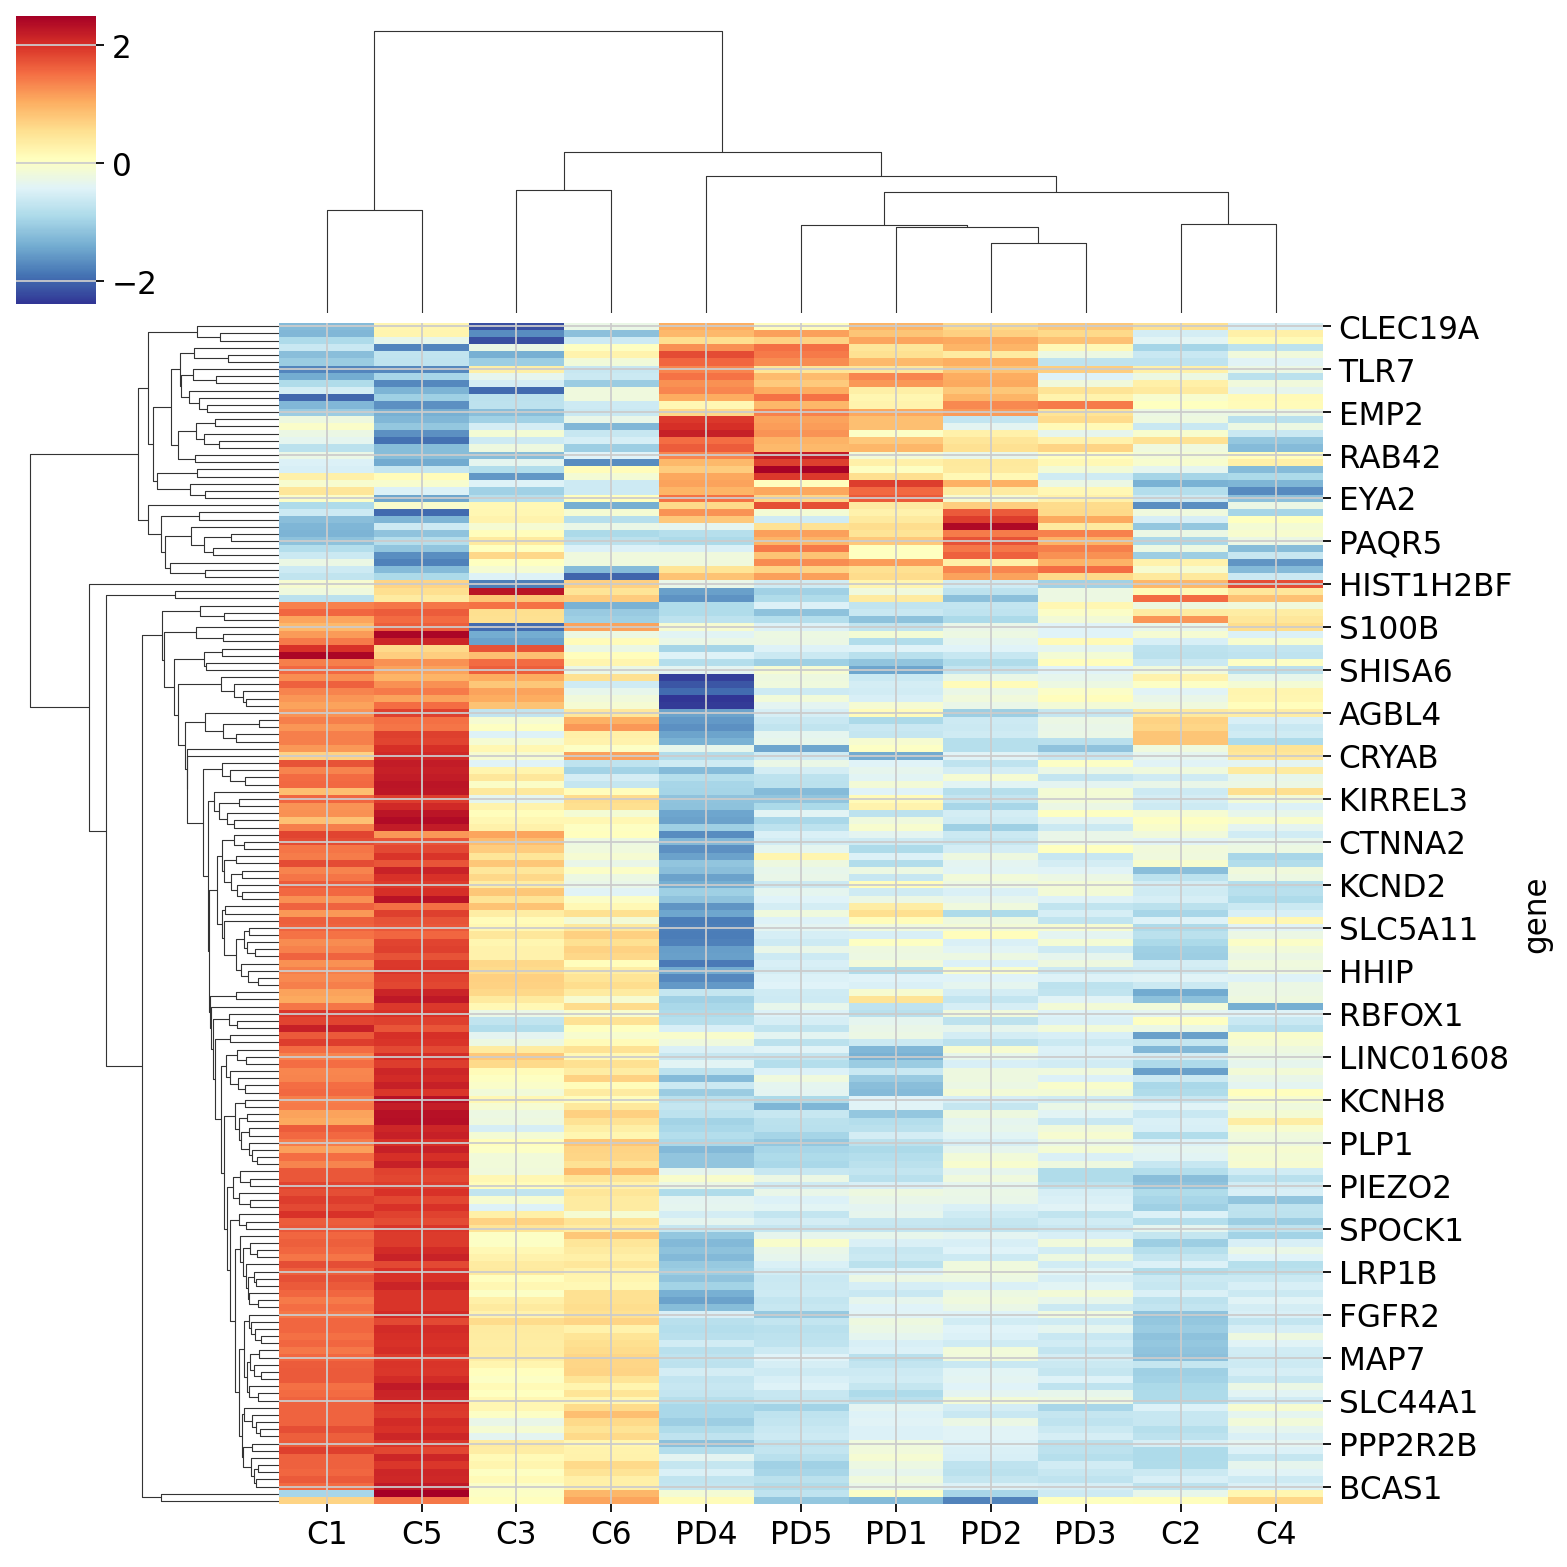

In [243]:
ax = sns.clustermap(heat_map, z_score=0, cmap='RdYlBu_r')

In [244]:
import sanbomics
from sanbomics.plots import volcano

In [245]:
dds

AnnData object with n_obs × n_vars = 11 × 1768
    obs: 'condition'
    var: 'n_cells'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [281]:
de.to_csv('/home/supakorn/rscript/results/GSE157783_deseq2.csv')

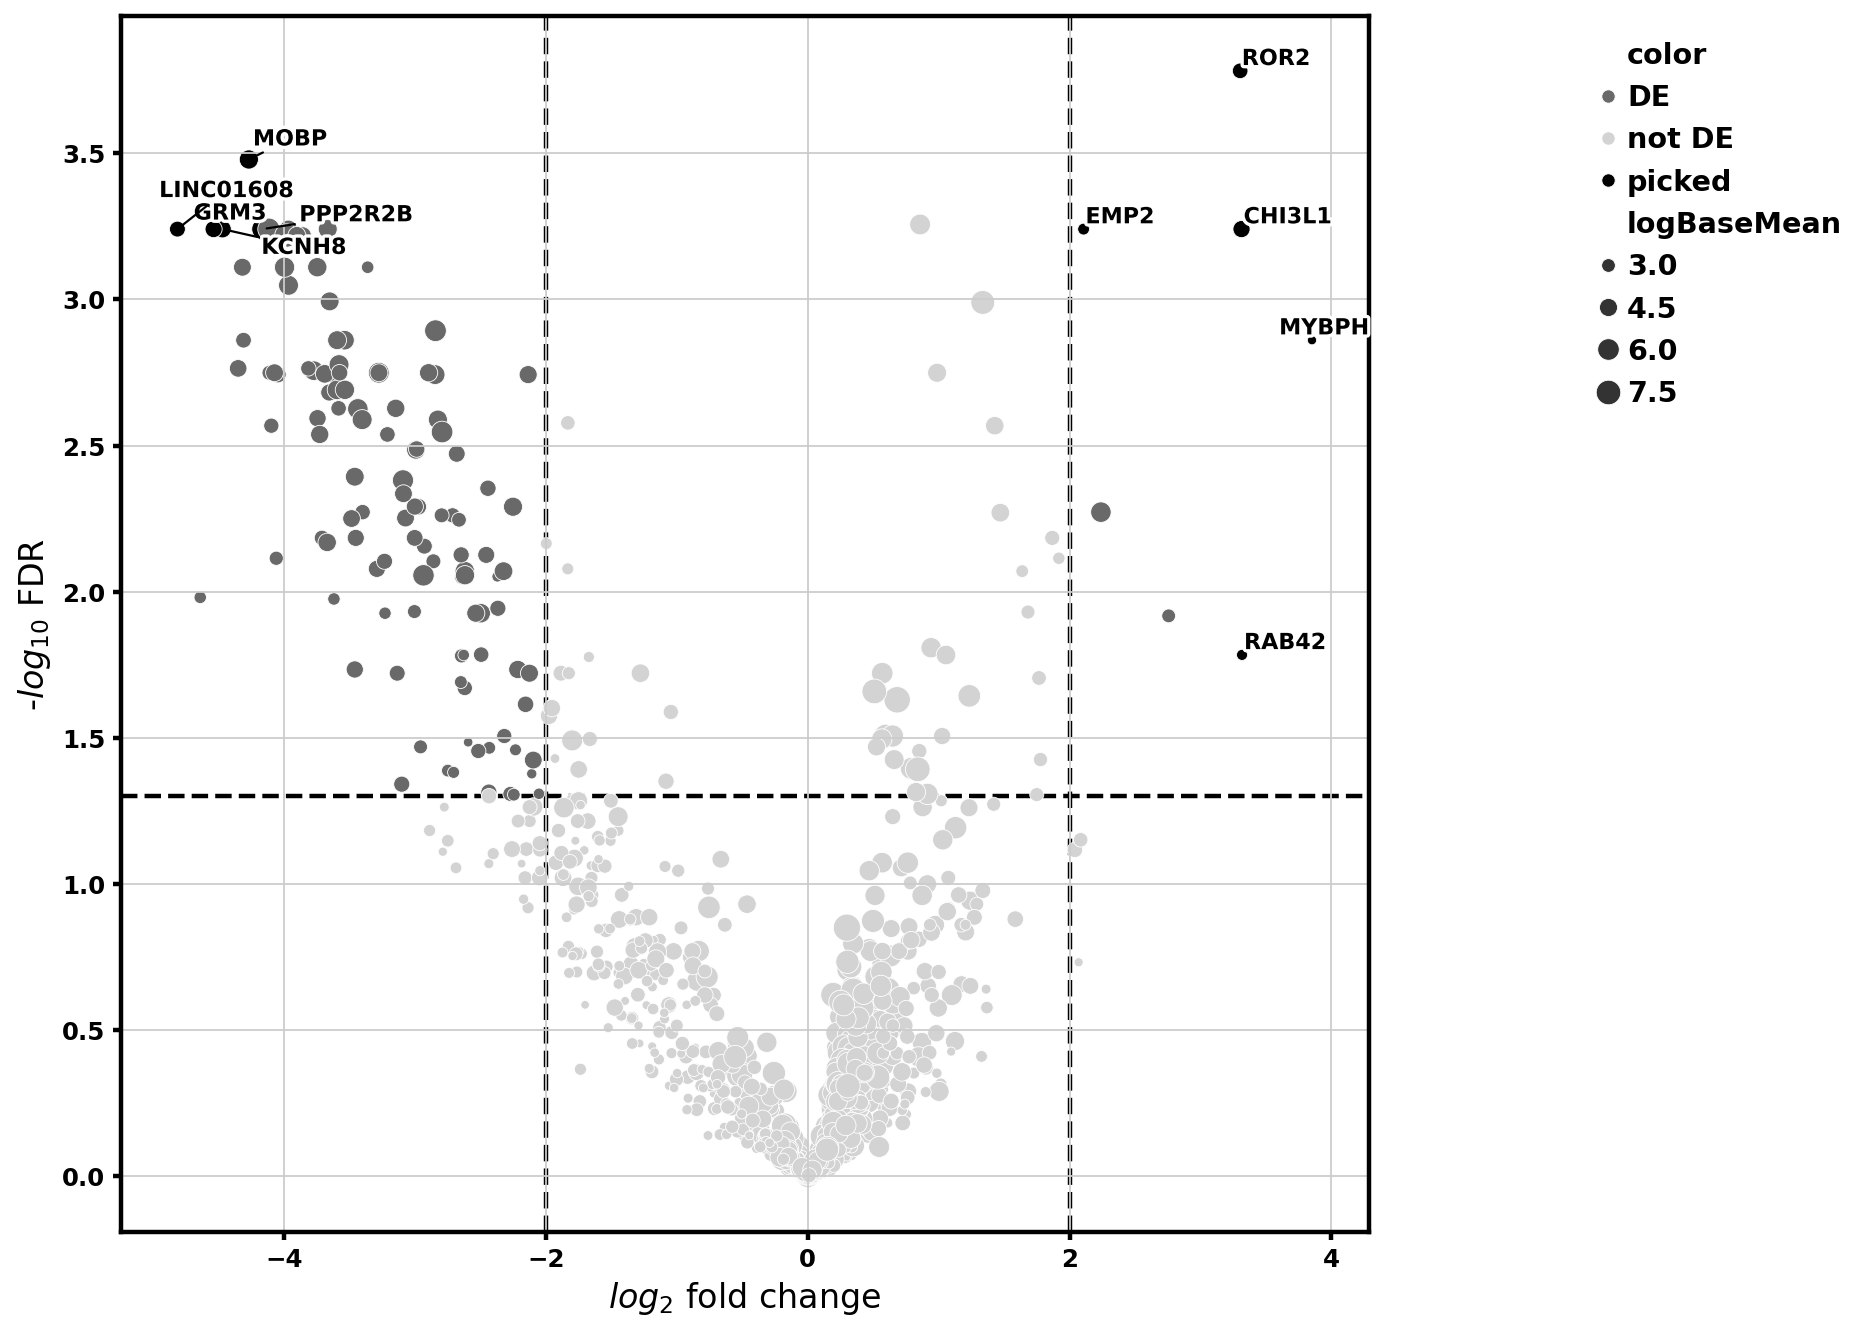

In [278]:
volcano(de, 
        symbol='gene_symbol', 
        top_right_frame = True,
        to_label = 5,
        log2fc_thresh=2,
        baseMean='baseMean',
        figsize=(10,10))

In [282]:
adata.write(results_file)